In [1]:
import pandas as pd
from trueskill import Rating, quality_1vs1, rate_1vs1, quality, rate, global_env, choose_backend,  backends, setup
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from IPython.display import display
from ipywidgets import widgets
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#!pip install --upgrade pip
#!pip install ipywidgets
!python --version

Python 2.7.10


In [15]:
get_teams_by_division(df)

,division,compID,location,date,college,first_name,last_name,position,result,score
0,DI,799,"Deland, FL",2018-02-23,Stetson,Carly,Perales,1,1,"21-12, 21-15"
1,DI,799,"Deland, FL",2018-02-23,Stetson,Sunniva,Helland-Hansen,1,1,"21-12, 21-15"
2,DI,799,"Deland, FL",2018-02-23,Stetson,Sammee,Thomas,2,1,"21-18, 21-16"
3,DI,799,"Deland, FL",2018-02-23,Stetson,Darby,Dunn,2,1,"21-18, 21-16"
4,DI,799,"Deland, FL",2018-02-23,Stetson,Quinci,Birker,3,1,"21-17, 21-17"
5,DI,799,"Deland, FL",2018-02-23,Stetson,Rebecca,Ingram,3,1,"21-17, 21-17"
6,DI,799,"Deland, FL",2018-02-23,Stetson,Rachel,Noble,4,1,"21-10, 21-8"
7,DI,799,"Deland, FL",2018-02-23,Stetson,Samantha,Harris,4,1,"21-10, 21-8"
8,DI,799,"Deland, FL",2018-02-23,Stetson,Katinka,Krahn,5,1,"21-9, 21-10"
9,DI,799,"Deland, FL",2018-02-23,Stetson,Alexa,Richardson,5,1,"21-9, 21-10"


In [13]:
df.columns

Index([u'division', u'compID', u'location', u'date', u'college', u'first_name',
       u'last_name', u'position', u'result', u'score'],
      dtype='object')

In [3]:
df = pd.read_csv('Data/Competition.csv').drop_duplicates()

In [304]:
sort_order = ['date', 'compID', 'position', 'result']

#UTILITIES
def strip_all_strings_in_df(df_, cols_):
    for s in cols_:
        df_[s] = df_[s].apply(lambda x: x.strip())
    return df_

#LOAD DATA
def get_competition_info(df_, div_='DI'):  
    df_ = get_teams_by_division(df_, div_)                                                      
    df_ = strip_all_strings_in_df(df_, ['first_name', 'last_name', 'college', 'location', 'division', 'score'])
    df_['date'] = pd.to_datetime(df_['date'], errors = 'coerce')
    df_ = df_.groupby('compID') \
        .filter(lambda x: len(x) == 20) \
        .sort_values(['date', 'compID', 'position', 'result'], ascending=True) \
        .reset_index() \
        .iloc[:,1:]
    return df_

#GET TEAM INFO
def get_teams_by_division(df_, div_='DI'):
    df_ = df_[df_["division"] == div_].drop_duplicates() \
        .reset_index().iloc[:,1:] \
        .sort_values(sort_order, ascending=True)
    return df_

#SETTING RATINGS
def set_default_player_rating(df_, div_='DI'): 
    df_players_ = df_.loc[:, ['division',  'college', 'first_name', 'last_name', 'mu', 'sigma']].copy() \
                    .drop_duplicates()
    df_players_ = strip_all_strings_in_df(df_players_, ['division',  'college', 'first_name', 'last_name'])
    df_players_ = df_players_[df_players_.division == div_]
    df_players_.loc[:,'mu'] = Rating().mu
    df_players_['sigma'] = Rating().sigma
    df_players_ = df_players_.sort_values(['last_name', 'first_name', 'college'], ascending=True) \
        .drop_duplicates() \
        .reset_index() \
        .loc[:, ['division',  'college', 'first_name', 'last_name',  'mu', 'sigma']]
    return df_players_


#GETTING RATINGS
def get_player_ratings_from_match(df_, fname_, lname_, college_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def set_player_ratings_after_match(df_, fname_, lname_, college_, position_,k_factor_, rating_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu + k_factor_[int(position_)-1]
    #df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu
    df_.iloc[player_idx,  df_.columns.get_loc('sigma')] = rating_.sigma
    
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def create_ratings_from_matches(df_, k_factor_=[0,0,0,0,0], div_='DI'):
    df_matches = get_competition_info(df_, div_)
    df_players = set_default_player_rating(df_, div_)

    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

        hist_dict[counter] = df_matches.iloc[value].merge(df_players, \
                                                          left_on=['first_name', 'last_name', 'college'], 
                                                          right_on=['first_name', 'last_name', 'college'], 
                                                          how='inner')
        counter += 1

    df_match_history = pd.concat(hist_dict.values(), axis=0) \
                        .sort_values(['date','compID'], ascending=True) \
                        .reset_index() \
                        .iloc[:,1:] \
                        .rename(columns={'division_y': 'division'})
    df_match_history['name'] = df_match_history['first_name'] + " " + df_match_history['last_name']
    
    
    df_match_history = set_primary_position( df_match_history)
    
    d = {'matches': df_matches, 'match_history': df_match_history, 'players':  df_players}
    return d

def set_primary_position(df_):
    df_['count_max'] = df_.groupby(['college', 'name', 'position'])['position'].transform('count')
    df_['count at primary position'] = df_.groupby(['college','name'])['count_max'].transform('max')
    idx = df_[df_['count at primary position'] == df_['count_max']]

    #primary_position = strip_all_strings_in_df(primary_position, ['college','name'])
    primary_position = idx.loc[:, ['college','name', 'position']]
    primary_position['position'] = primary_position.groupby(['name'])['position'].transform('min')
    primary_position = primary_position.drop_duplicates()

    temp = df_.merge(primary_position, on=['college', 'name'])
    temp.rename(columns = {'position_y': 'primary position', 'position_x': 'position'}, inplace=True)
    temp = temp.loc[:,['date','compID', 'location', 'first_name', 'last_name', 'name', \
          'position', 'primary position', 'college','division' ,'result', 'mu', 'sigma' ]]
    return temp


def plot_rating_distribution(df_):
    d = df_ \
        .sort_values('date', ascending=True) \
        .groupby(['first_name', 'last_name', 'college']) \
        .last() \
        .sort_values('mu', ascending=False) \
        .reset_index()

    current_palette = sns.color_palette()

    f =  plt.figure(figsize=(30, 15))
    grid = plt.GridSpec(3, 5, wspace=.4, hspace=0.3)
    summary_ax = f.add_subplot(grid[:2, 0:])
    pos_ax = [f.add_subplot(grid[2, 4+(i*-1)], xticklabels=[], sharey=summary_ax) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=summary_ax,  color=current_palette[i], axlabel='Rating', hist_kws=dict(alpha=.1)) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=pos_ax[i], color=current_palette[i], axlabel='Position '+str(i+1))  for i in range(5)]
    return d

def get_top_players(df_, position_='all'):
    if position_ == 'all':
        df_top_players_ = df_.sort_values(['date', 'compID'], ascending=True).copy()
    else:
        df_top_players_ = df_[df_['primary position'] == position_].sort_values(['date', 'compID'], ascending=True).copy()
    df_top_players_ = df_top_players_.groupby(['first_name', 'last_name', 'college', 'division']) \
                                    .last() \
                                    .sort_values('mu', ascending=False) \
                                    .reset_index()
        
    df_top_players_['rank'] = df_top_players_.index+1
    df_top_players_ = df_top_players_.loc[:,['rank','name', 'college', 'division', 'mu', 'primary position', 'date']]
    df_top_players_.columns= ['rank','name', 'college', 'division', 'rating', 'primary position' ,'date']
    return df_top_players_


def compare_rank_to_avca_all_americans(df_):
    view = get_top_players(df_)
    view[view.name.isin([
                        "Torrey Van Winden",
                        "Tia Miric",
                        "Federica Frasca",
                        "Margherita Bianchin",
                        "Victoria Paranagua",
                        "Vanessa Freire",
                        "Claire Coppola",
                        "Kristen Nuss",
                        "Madeline Mertz",
                        "Kaylie Mchugh",
                        "Megan McNamara",
                        "Nicole McNamara",
                        "Emily Maglio",
                        "Ka'iwi Schucht",
                        "Abril Bustamante",
                        "Tina Graudina",
                        "Lily Justine",
                        "Sarah Sponcil",
                        "Deahna Kraft",
                        "Corinne Quiggle",
                        "Nele Barber",
                        "Molly Turner",
    ])]

def get_player_rating(df, a):
    temp_df = df[df['name'] == a]
    r = Rating(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0], temp_df.groupby(['sigma'])['date'].last().sort_values(ascending=False).index[0])
    return r



def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    #print temp_df
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df['primary position'].unique()[-1])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    return df_summary

def plot_team_players_history(df, college):
    df_team_history = df[df.college == college].sort_values('date', ascending=True)
    playercount = len(df_team_history.name.unique())
    palette = sns.color_palette("mako_r", playercount)
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(data=df_team_history, x="date", y="mu", hue="name", \
                 style="primary position", markers=True, palette=palette,ci=None)

## No Spread Factor Applied

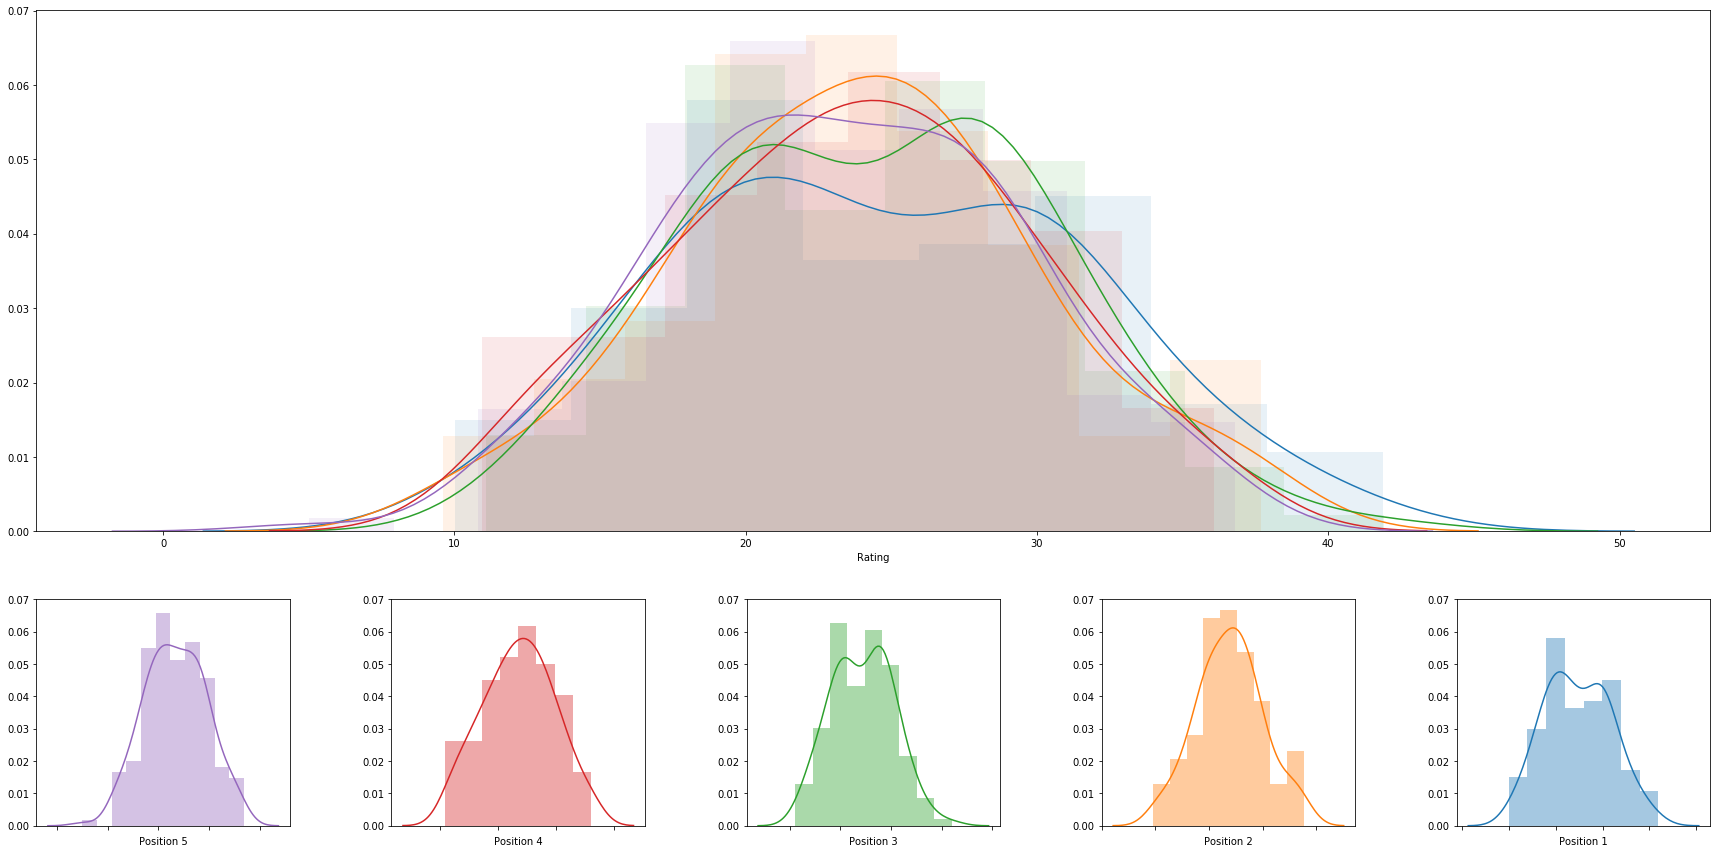

In [555]:
d = create_ratings_from_matches(df, [0,0,0,0, 0])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('000_000_000_000_000.csv')

## Introduce overlap - Mike's requested spread factor

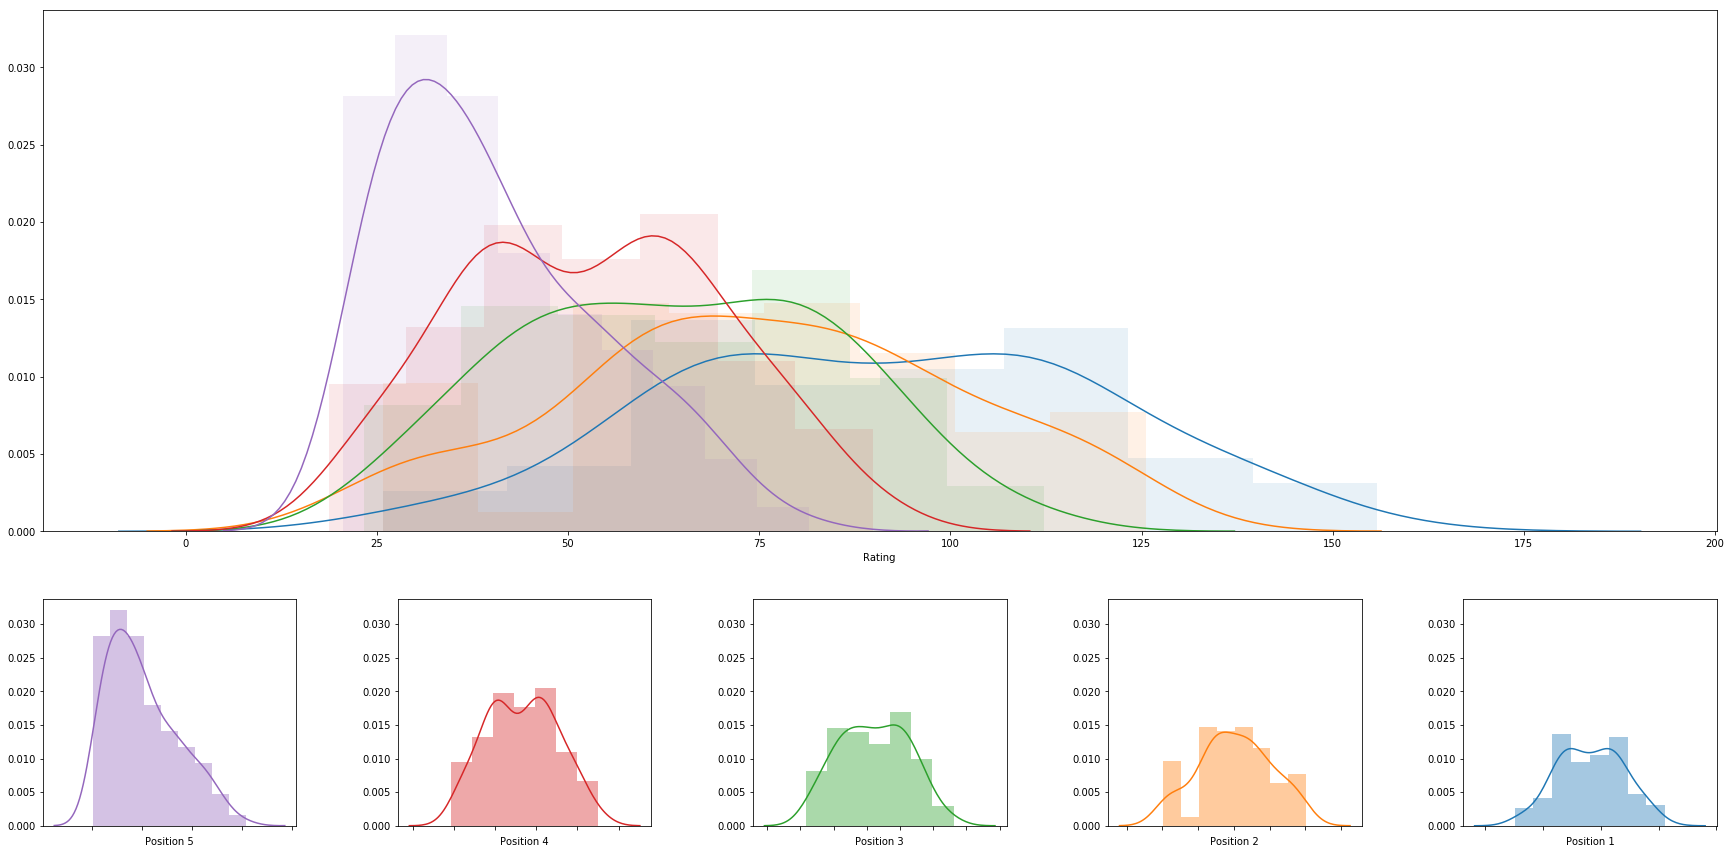

In [556]:
d = create_ratings_from_matches(df, [2.25, 1.7, 1.2, .75, .25])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('225_170_120_075_025.csv')

## Minimize spread factor, but keep overlap

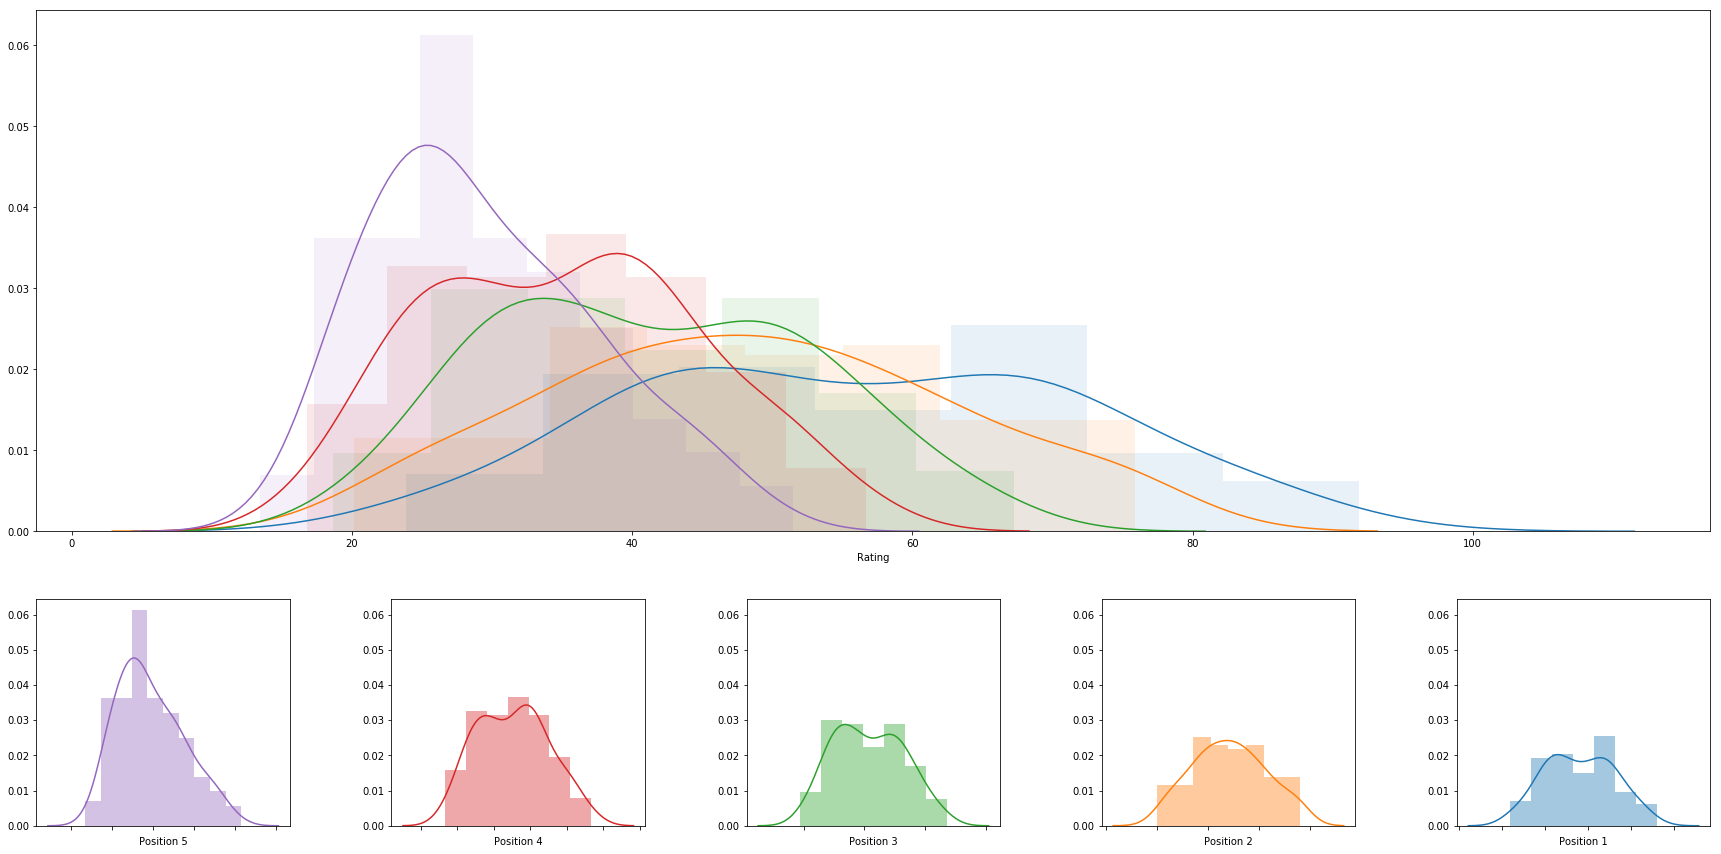

In [557]:
d = create_ratings_from_matches(df, [1.1, .9, .5, .3, 0])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('011_009_005_003_000.csv')

## Between minimized spread factor and Sat night spread - add some points for flight 5

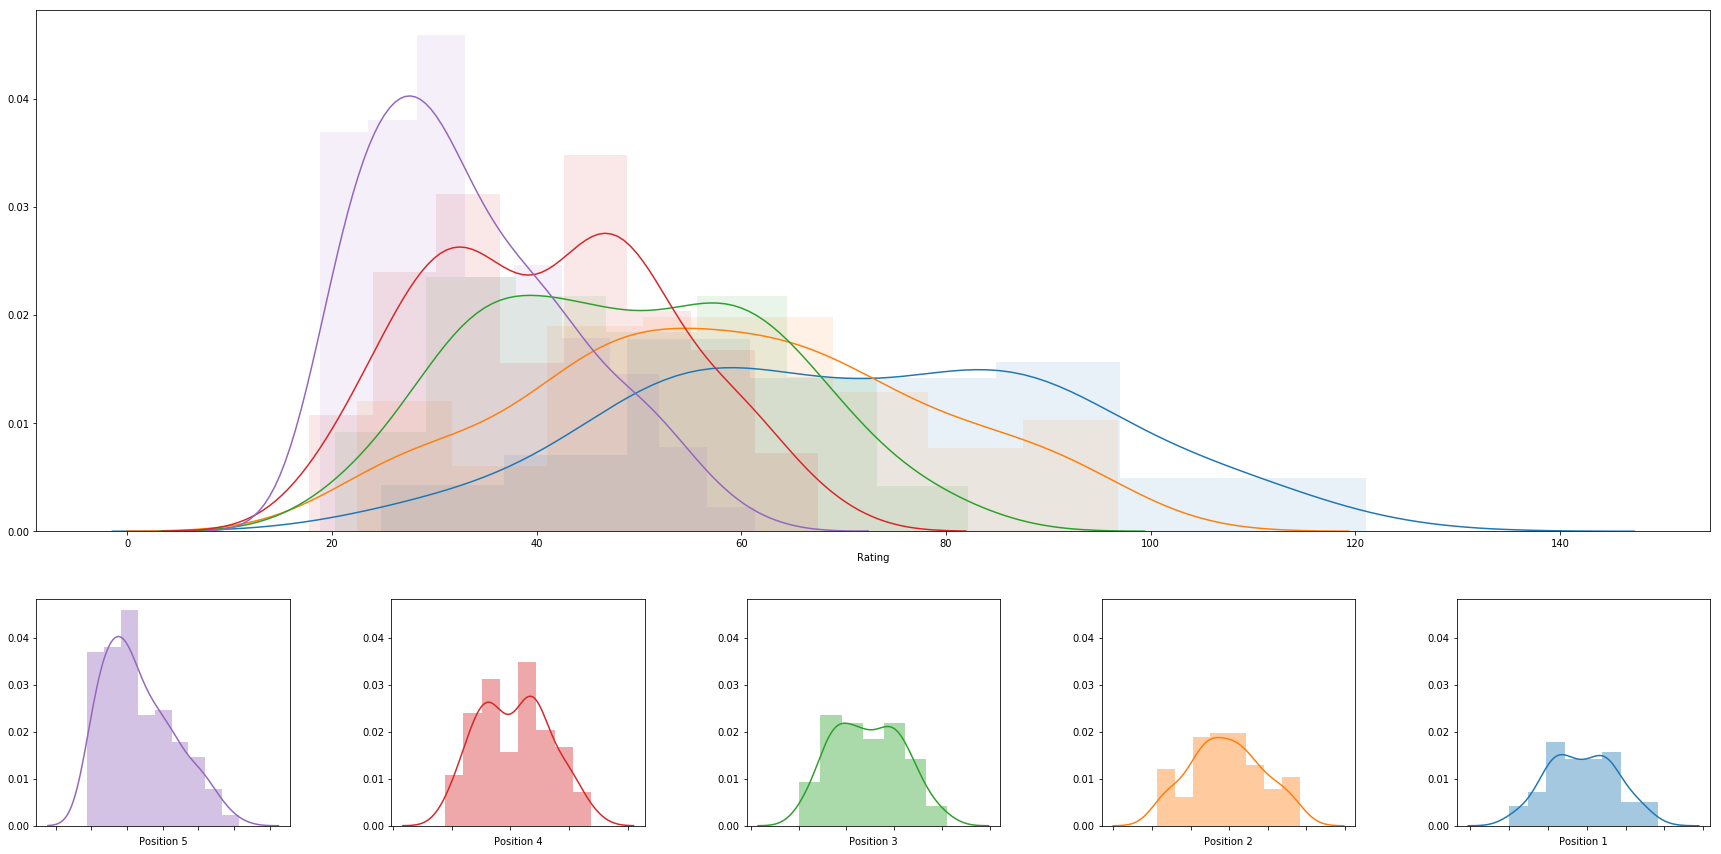

In [297]:
d = create_ratings_from_matches(df, [1.7, 1.2, .7, .45, .1])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('170_120_070_045_010.csv')

In [298]:
df_top_players = get_top_players(d['match_history'], position_='all')
df_top_players

,rank,name,college,division,rating,primary position,date
0,1,Abril Bustamante,USC,DI,121.023633,1,2018-05-05
1,2,Megan McNamara,UCLA,DI,111.475752,1,2018-05-06
2,3,Nicole McNamara,UCLA,DI,111.475752,1,2018-05-06
3,4,Emily Maglio,Hawaii,DI,110.391574,1,2018-05-06
4,5,Ka'iwi Schucht,Hawaii,DI,110.391574,1,2018-05-06
5,6,Tina Graudina,USC,DI,109.197178,1,2018-05-05
6,7,Victoria Paranagua,Florida State,DI,109.003916,1,2018-05-05
7,8,Claire Coppola,LSU,DI,105.810655,1,2018-05-04
8,9,Kristen Nuss,LSU,DI,105.810655,1,2018-05-04
9,10,Vanessa Freire,Florida State,DI,102.695828,1,2018-05-05


,rank,name,college,division,rating,primary position,date
15,16,Katie Smith,South Carolina,DI,96.770154,2,2018-05-04
43,44,Shannon Williams,South Carolina,DI,87.387569,1,2018-05-04
44,45,Ali Denney,South Carolina,DI,87.387569,1,2018-05-04
51,52,Cadie Bates,South Carolina,DI,84.341369,2,2018-05-04
141,142,Carly Schneider,South Carolina,DI,64.696564,3,2018-05-04
152,153,Julia Mannisto,South Carolina,DI,62.986831,3,2018-05-04
189,190,Macie Tendrich,South Carolina,DI,59.581086,4,2018-05-04
190,191,Leah Perri,South Carolina,DI,59.581086,4,2018-05-04
359,360,Lydia Dimke,South Carolina,DI,45.202219,2,2018-05-04
411,412,Aubrey Ezell,South Carolina,DI,41.919770,2,2018-04-14


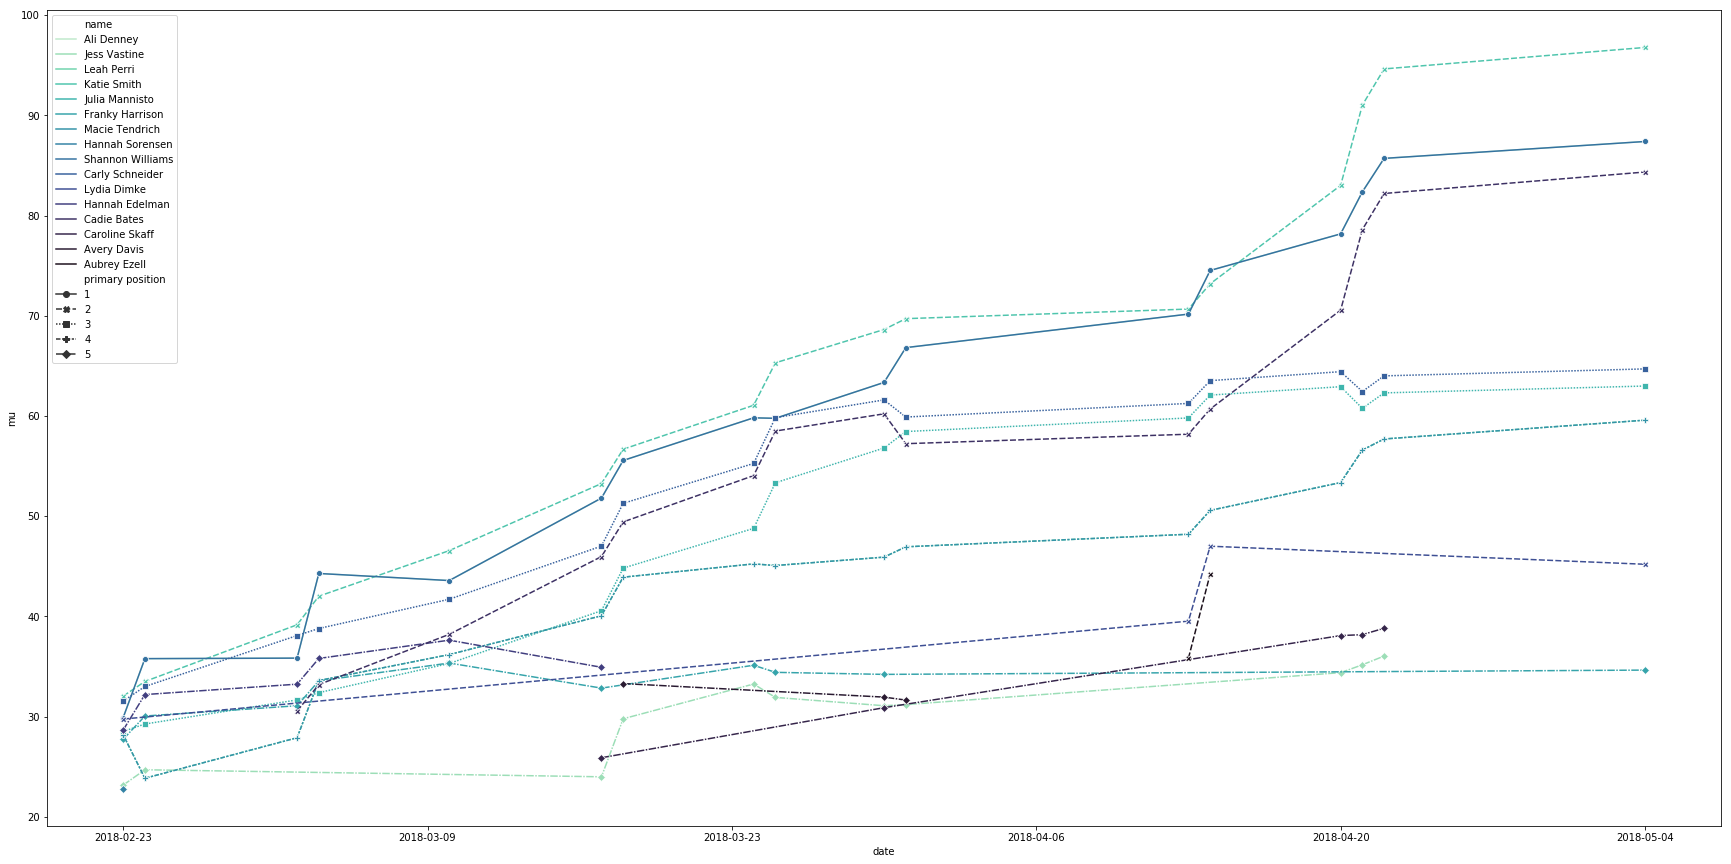

In [299]:
plot_team_players_history(d['match_history'], 'South Carolina')  
df_top_players[df_top_players.college == 'South Carolina']

,rank,name,college,division,rating,primary position,date
17,18,Corinne Quiggle,Pepperdine,DI,94.668937,2,2018-05-05
18,19,Deahna Kraft,Pepperdine,DI,94.668937,2,2018-05-05
39,40,Brook Bauer,Pepperdine,DI,87.642846,1,2018-05-05
40,41,Madalyn Roh,Pepperdine,DI,87.642846,1,2018-05-05
125,126,Gigi Hernandez,Pepperdine,DI,67.307688,3,2018-05-05
126,127,Heidi Dyer,Pepperdine,DI,67.307688,3,2018-05-05
155,156,Alexis Filippone,Pepperdine,DI,62.456411,4,2018-05-05
156,157,Skylar Caputo,Pepperdine,DI,62.456411,4,2018-05-05
300,301,Nikki Lyons,Pepperdine,DI,49.687981,5,2018-05-05
327,328,Maddie Dilfer,Pepperdine,DI,47.339166,5,2018-05-05


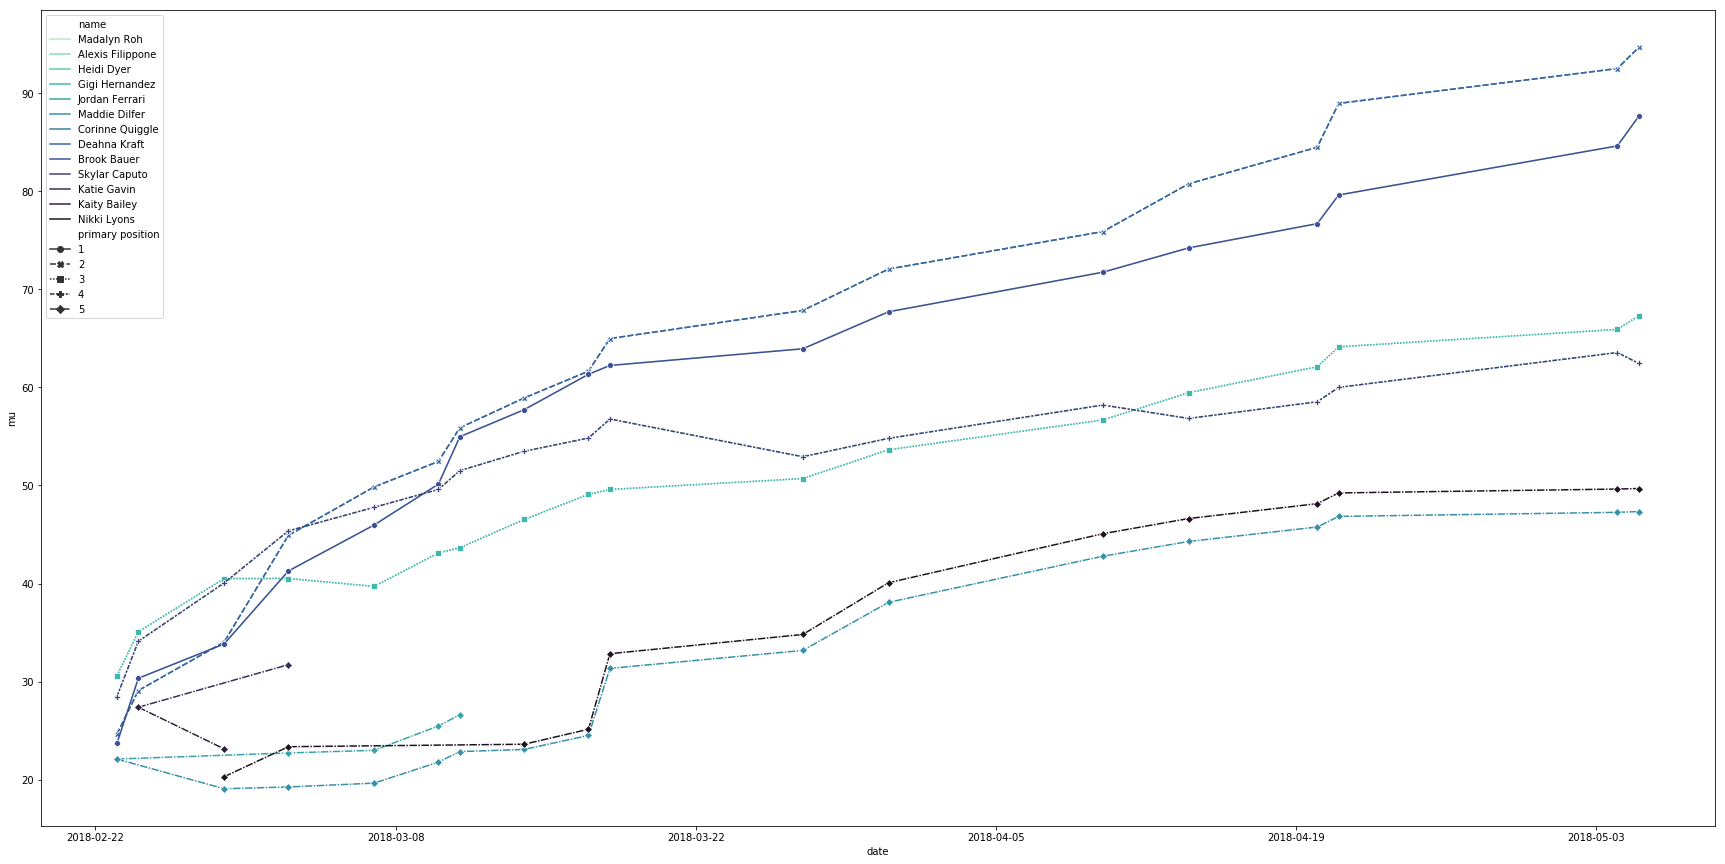

In [300]:
plot_team_players_history(d['match_history'], 'Pepperdine')   
df_top_players[df_top_players.college == 'Pepperdine']

,rank,name,college,division,rating,primary position,date
3,4,Emily Maglio,Hawaii,DI,110.391574,1,2018-05-06
4,5,Ka'iwi Schucht,Hawaii,DI,110.391574,1,2018-05-06
28,29,Morgan Martin,Hawaii,DI,91.038288,2,2018-05-06
32,33,Lea Monkhouse,Hawaii,DI,89.379120,2,2018-05-06
60,61,Carly Kan,Hawaii,DI,82.125819,3,2018-05-06
70,71,Laurel Weaver,Hawaii,DI,80.278415,3,2018-05-06
121,122,Ari Homayun,Hawaii,DI,67.516901,4,2018-05-06
122,123,Amy Ozee,Hawaii,DI,67.516901,4,2018-05-06
247,248,Hannah Zalopany,Hawaii,DI,54.229599,5,2018-05-06
291,292,Paige Dreeuws,Hawaii,DI,50.417680,5,2018-05-06


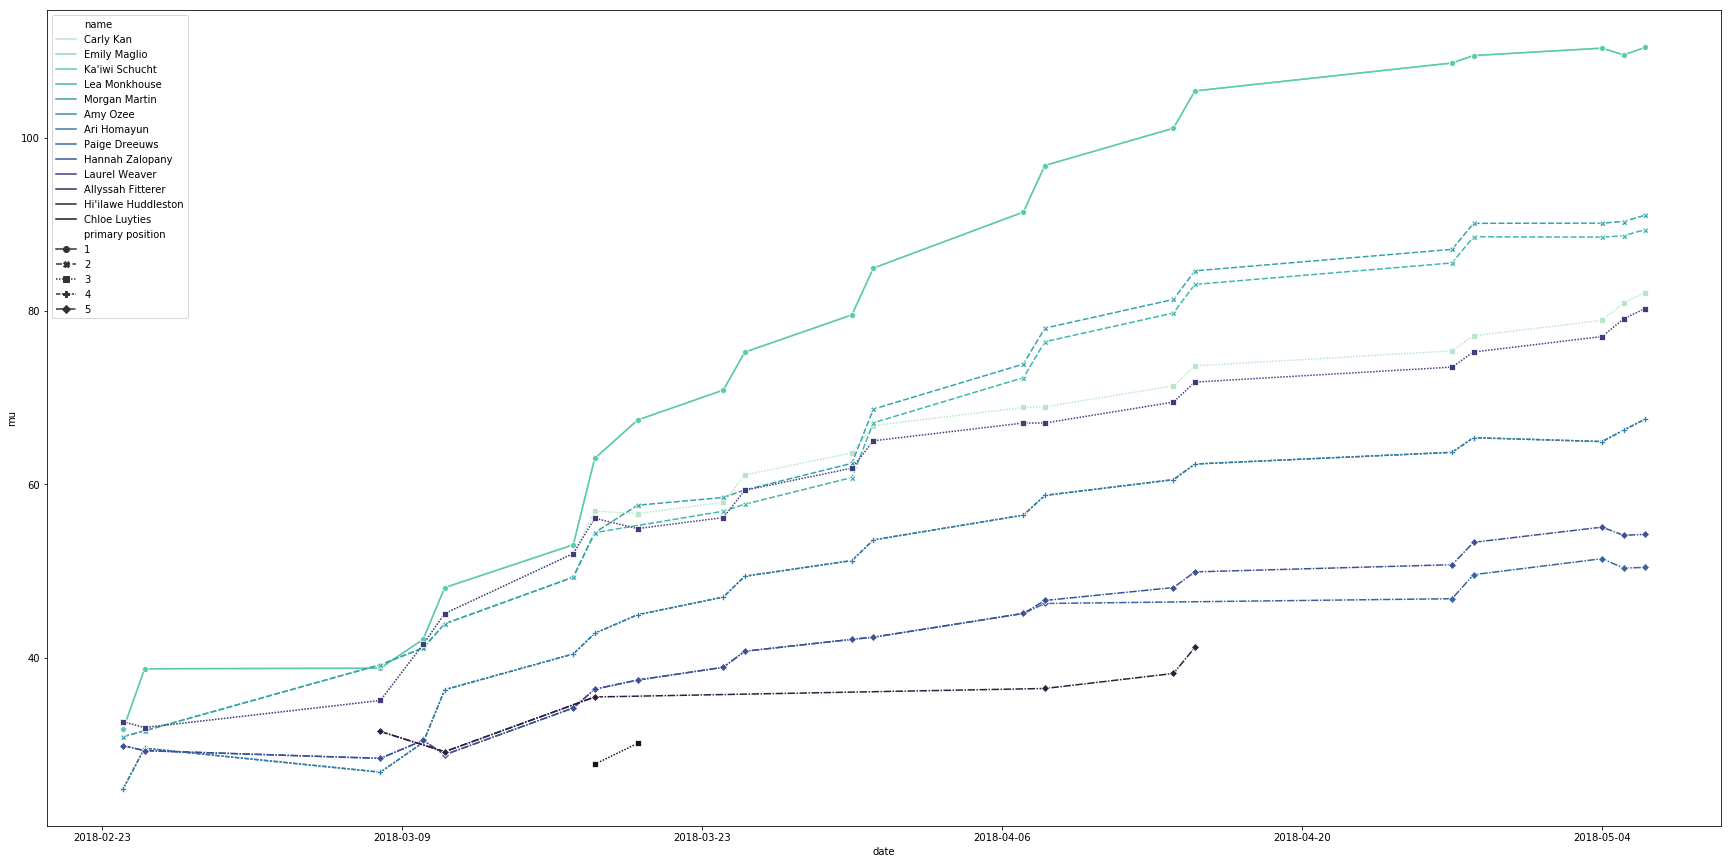

In [301]:
plot_team_players_history(d['match_history'], 'Hawaii')     
df_top_players[df_top_players.college == 'Hawaii']

,rank,name,college,division,rating,primary position,date
1,2,Megan McNamara,UCLA,DI,111.475752,1,2018-05-06
2,3,Nicole McNamara,UCLA,DI,111.475752,1,2018-05-06
26,27,Lily Justine,UCLA,DI,91.582450,2,2018-05-06
27,28,Sarah Sponcil,UCLA,DI,91.582450,2,2018-05-06
93,94,Savvy Simo,UCLA,DI,72.918256,3,2018-05-06
124,125,Elise Zappia,UCLA,DI,67.481850,4,2018-05-06
142,143,Zana Muno,UCLA,DI,64.535900,3,2018-05-06
220,221,Izzy Carey,UCLA,DI,56.487923,5,2018-05-06
221,222,Megan Muret,UCLA,DI,56.487923,5,2018-05-06
231,232,Mac May,UCLA,DI,55.987476,4,2018-05-06


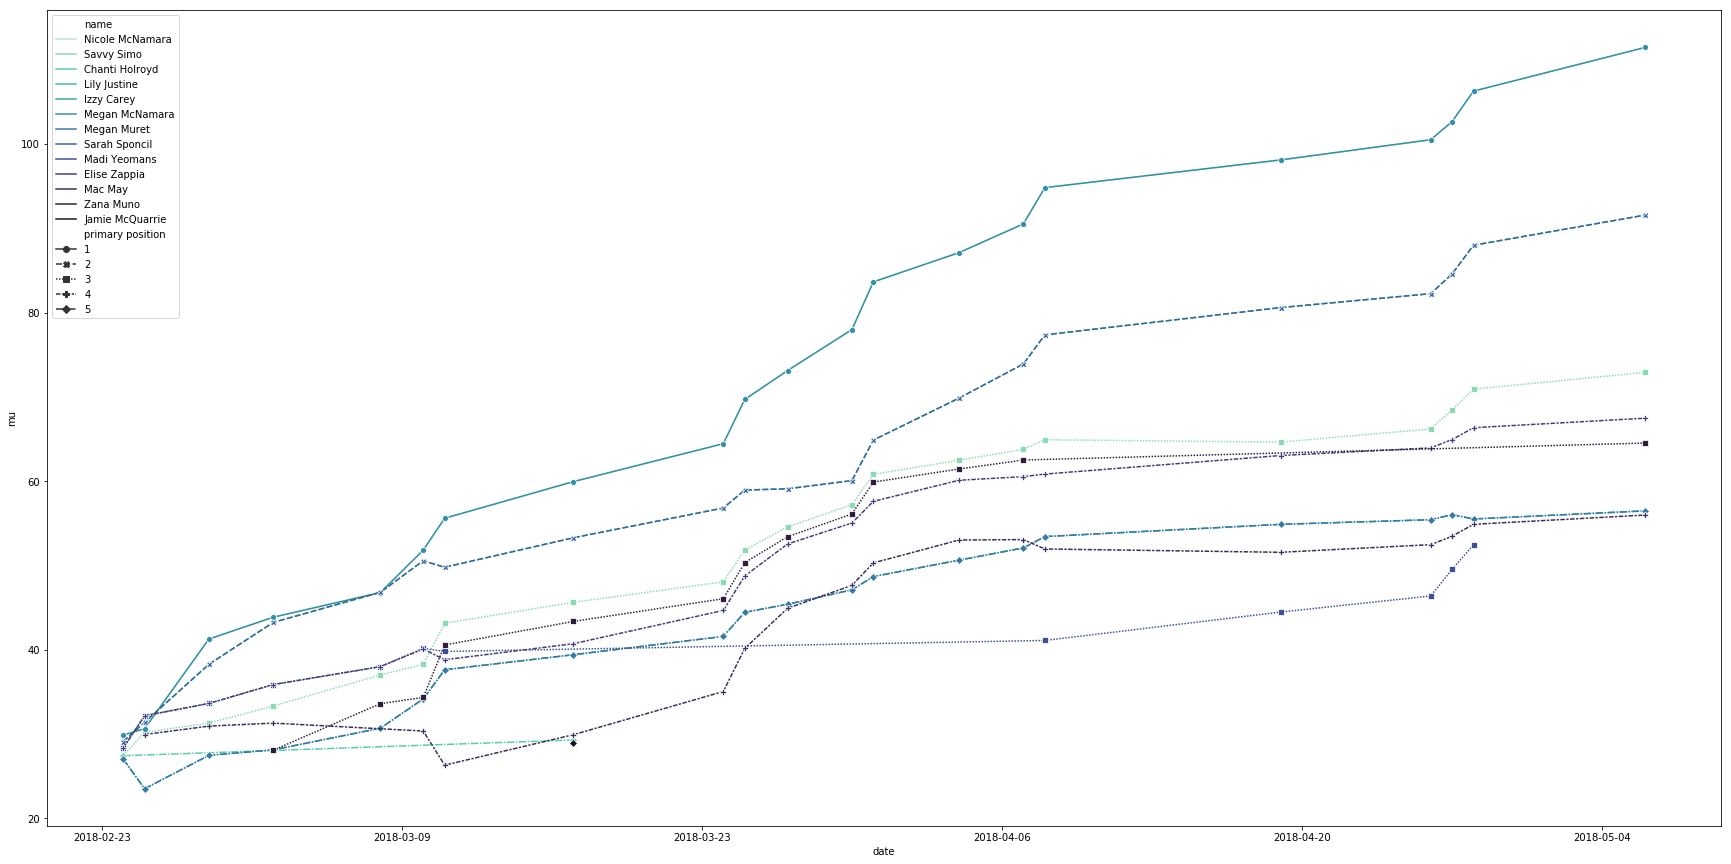

In [302]:
plot_team_players_history(d['match_history'], 'UCLA')     
df_top_players[df_top_players.college == 'UCLA']

,rank,name,college,division,rating,primary position,date
6,7,Victoria Paranagua,Florida State,DI,109.003916,1,2018-05-05
9,10,Vanessa Freire,Florida State,DI,102.695828,1,2018-05-05
31,32,Katie Horton,Florida State,DI,89.603565,2,2018-05-05
38,39,Hailey Luke,Florida State,DI,87.854222,2,2018-05-05
73,74,Sara Putt,Florida State,DI,78.991286,3,2018-05-05
79,80,Macy Jerger,Florida State,DI,75.780158,3,2018-05-05
162,163,Brooke Kuhlman,Florida State,DI,62.214704,4,2018-05-05
169,170,Francesca Goncalves,Florida State,DI,61.377658,5,2018-05-05
201,202,Molly McBain,Florida State,DI,58.896998,4,2018-05-05
292,293,Eva Torruella,Florida State,DI,50.318790,5,2018-04-22


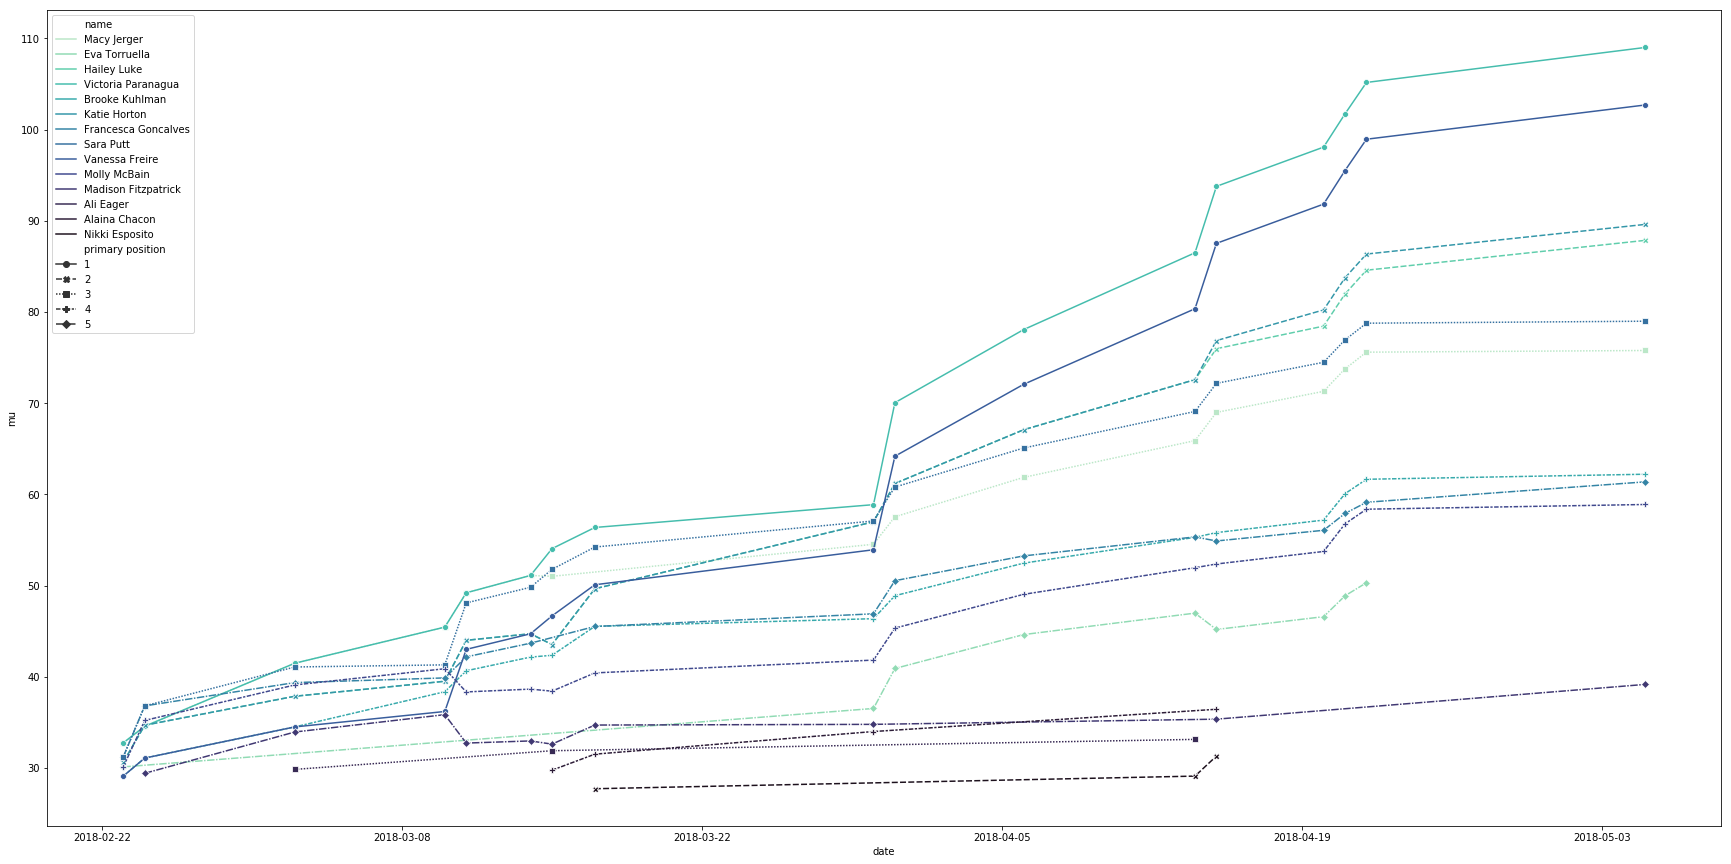

In [303]:
plot_team_players_history(d['match_history'], 'Florida State') 
df_top_players[df_top_players.college == 'Florida State']

,rank,name,college,division,rating,primary position,date
41,42,Olivia Macdonald,Arizona,DI,87.591401,1,2018-04-27
42,43,Natalie Anselmo,Arizona,DI,87.591401,1,2018-04-27
140,141,Kacey Nady,Arizona,DI,64.794925,2,2018-04-27
153,154,Hailey Devlin,Arizona,DI,62.917853,3,2018-04-27
168,169,Stephany Purdue,Arizona,DI,61.463495,3,2018-04-27
206,207,Olivia Hallaran,Arizona,DI,58.023269,2,2018-04-27
224,225,Jonny Baham,Arizona,DI,56.397049,4,2018-04-27
250,251,Brooke Burling,Arizona,DI,54.210413,4,2018-04-27
256,257,Makenna Martin,Arizona,DI,53.378642,5,2018-04-27
374,375,Mia Mason,Arizona,DI,43.904751,3,2018-03-31


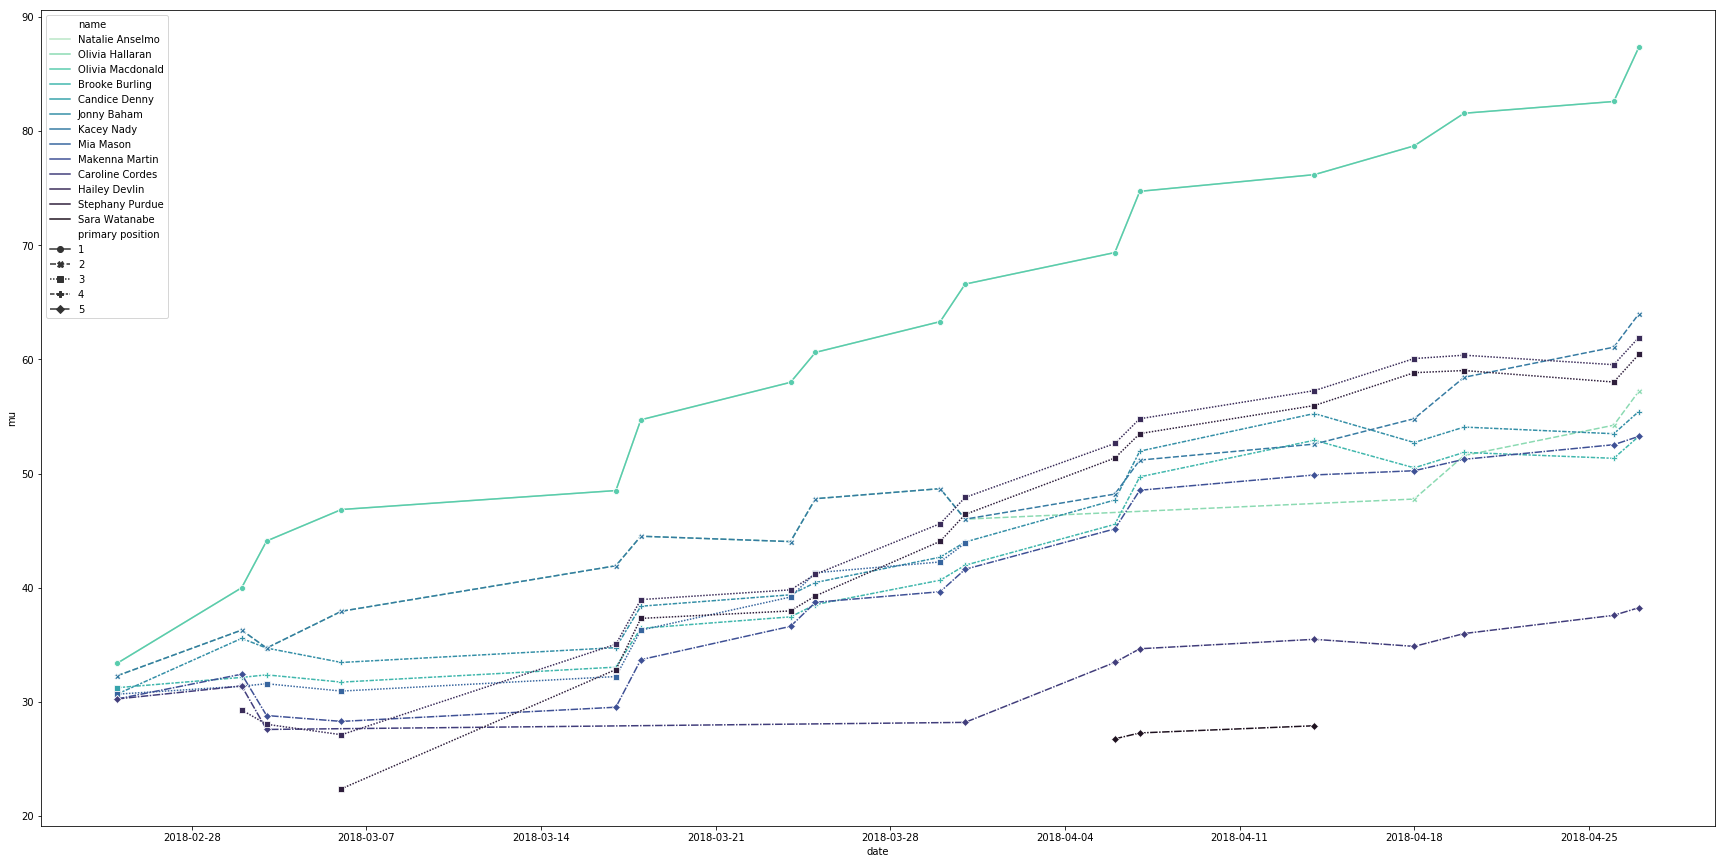

In [305]:
plot_team_players_history(d['match_history'], 'Arizona') 
df_top_players[df_top_players.college == 'Arizona']

,rank,name,college,division,rating,primary position,date
10,11,Nele Barber,Long Beach State,DI,101.434937,1,2018-04-28
11,12,Sasha Karelov,Long Beach State,DI,100.978356,1,2018-04-28
25,26,Rachel Nieto,Long Beach State,DI,92.622743,2,2018-04-28
75,76,Megan Kruidhof,Long Beach State,DI,77.063312,2,2018-04-28
135,136,Hailey Harward,Long Beach State,DI,65.732522,3,2018-04-28
147,148,Kristyna Adamcikova,Long Beach State,DI,63.254655,3,2018-04-27
174,175,Nicci Reinking,Long Beach State,DI,60.686474,4,2018-04-28
187,188,Zoi Konstantopoulou,Long Beach State,DI,59.813610,4,2018-04-28
229,230,Anete Brinke,Long Beach State,DI,56.181528,2,2018-04-28
280,281,Hannah Matt,Long Beach State,DI,50.886826,5,2018-04-28


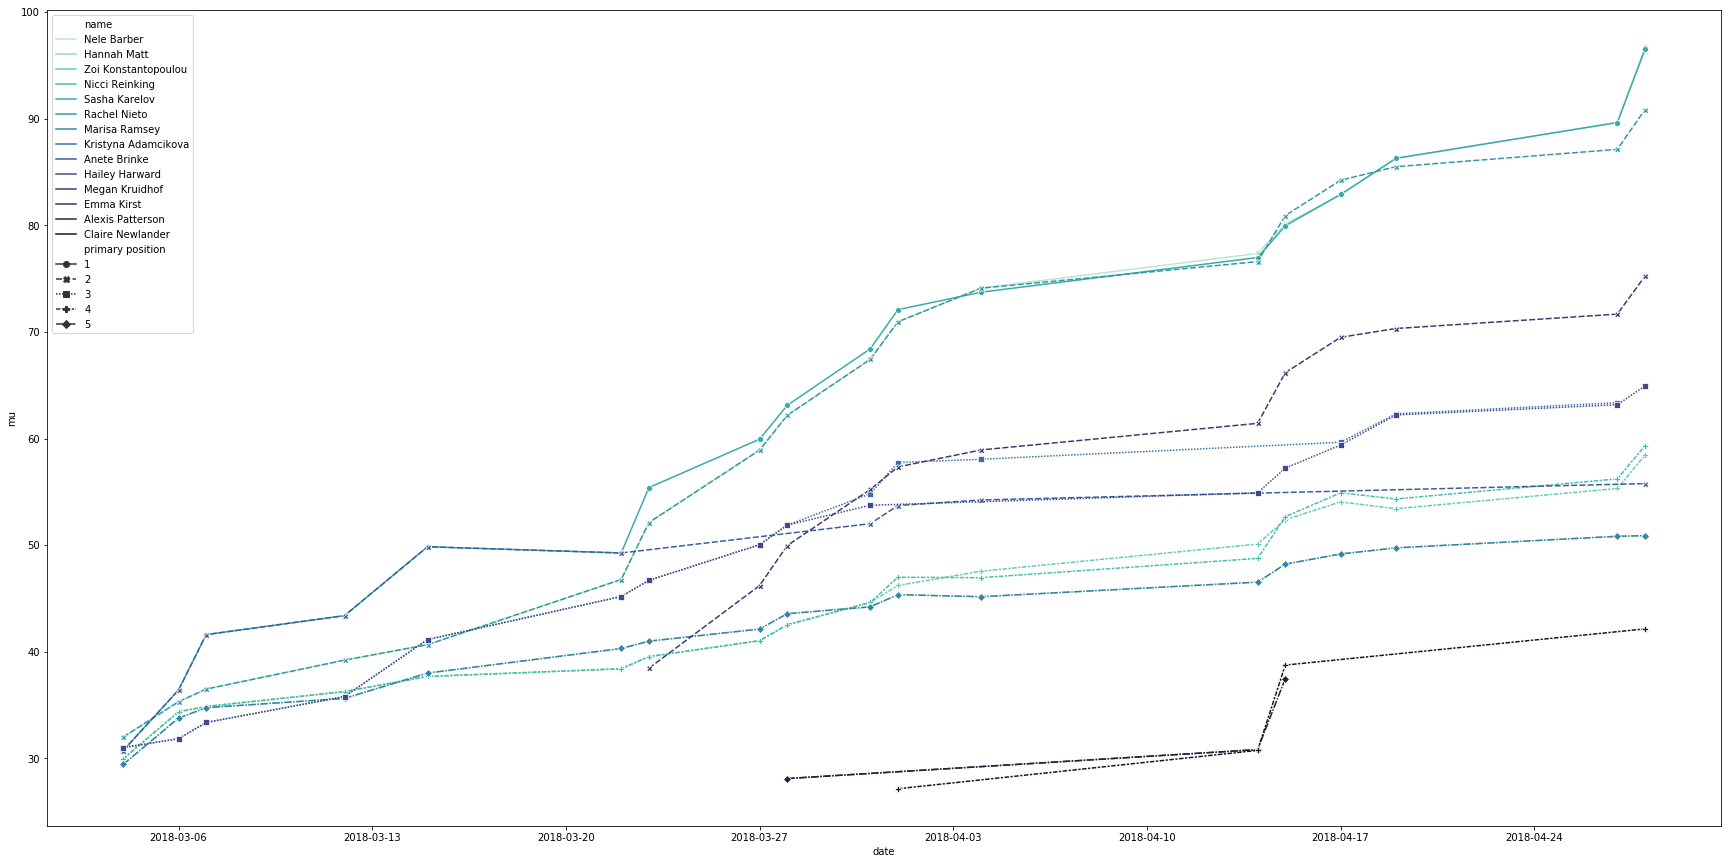

In [306]:
plot_team_players_history(d['match_history'], 'Long Beach State')
df_top_players[df_top_players.college == 'Long Beach State']

,rank,name,college,division,rating,primary position,date
19,20,Federica Frasca,FIU,DI,94.400986,1,2018-05-04
20,21,Margherita Bianchin,FIU,DI,94.400986,1,2018-05-04
109,110,Lina Bernier,FIU,DI,69.717533,3,2018-05-04
117,118,Dorina Klinger,FIU,DI,68.029289,2,2018-05-04
134,135,Erika Zembyla,FIU,DI,66.106742,2,2018-05-04
181,182,Katie Friesen,FIU,DI,60.318804,3,2018-05-04
215,216,Anabela Sataric,FIU,DI,57.154507,2,2018-05-04
243,244,Taija Thomas,FIU,DI,54.539162,5,2018-05-04
304,305,Mariana Dal Pozzo,FIU,DI,49.414173,5,2018-04-22
312,313,Natalia Giron,FIU,DI,48.838445,4,2018-05-04


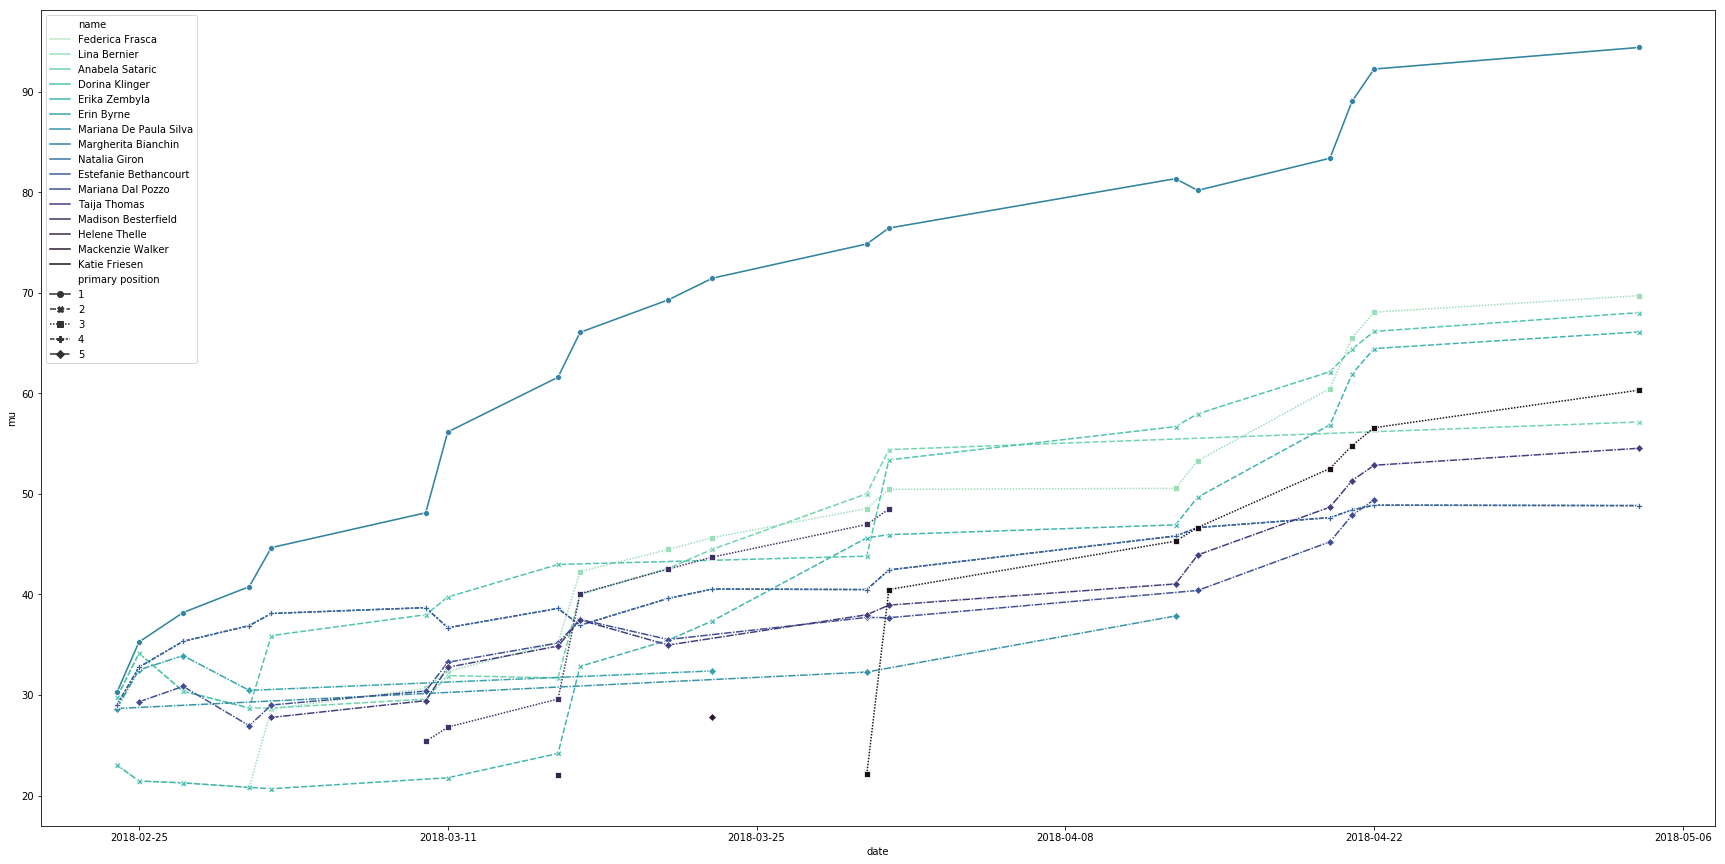

In [309]:
plot_team_players_history(d['match_history'], 'FIU')
df_top_players[df_top_players.college == 'FIU']

,rank,name,college,division,rating,primary position,date
12,13,Madeline Mertz,Tulane,DI,100.367408,1,2018-04-21
13,14,Kaylie Mchugh,Tulane,DI,100.367408,1,2018-04-21
99,100,Tarin Mergener,Tulane,DI,72.265172,2,2018-04-21
102,103,Lan Nguyen,Tulane,DI,71.955470,2,2018-04-21
150,151,Anna Chin,Tulane,DI,63.081980,3,2018-04-21
202,203,Lauren Orlich,Tulane,DI,58.145406,3,2018-04-21
257,258,Ashley Delgado,Tulane,DI,53.336305,4,2018-04-21
275,276,Rio Frohoff,Tulane,DI,51.489686,4,2018-04-21
310,311,Addison Hermstad,Tulane,DI,48.925462,4,2018-04-21
380,381,Gabriella Becerra,Tulane,DI,43.441307,4,2018-04-21


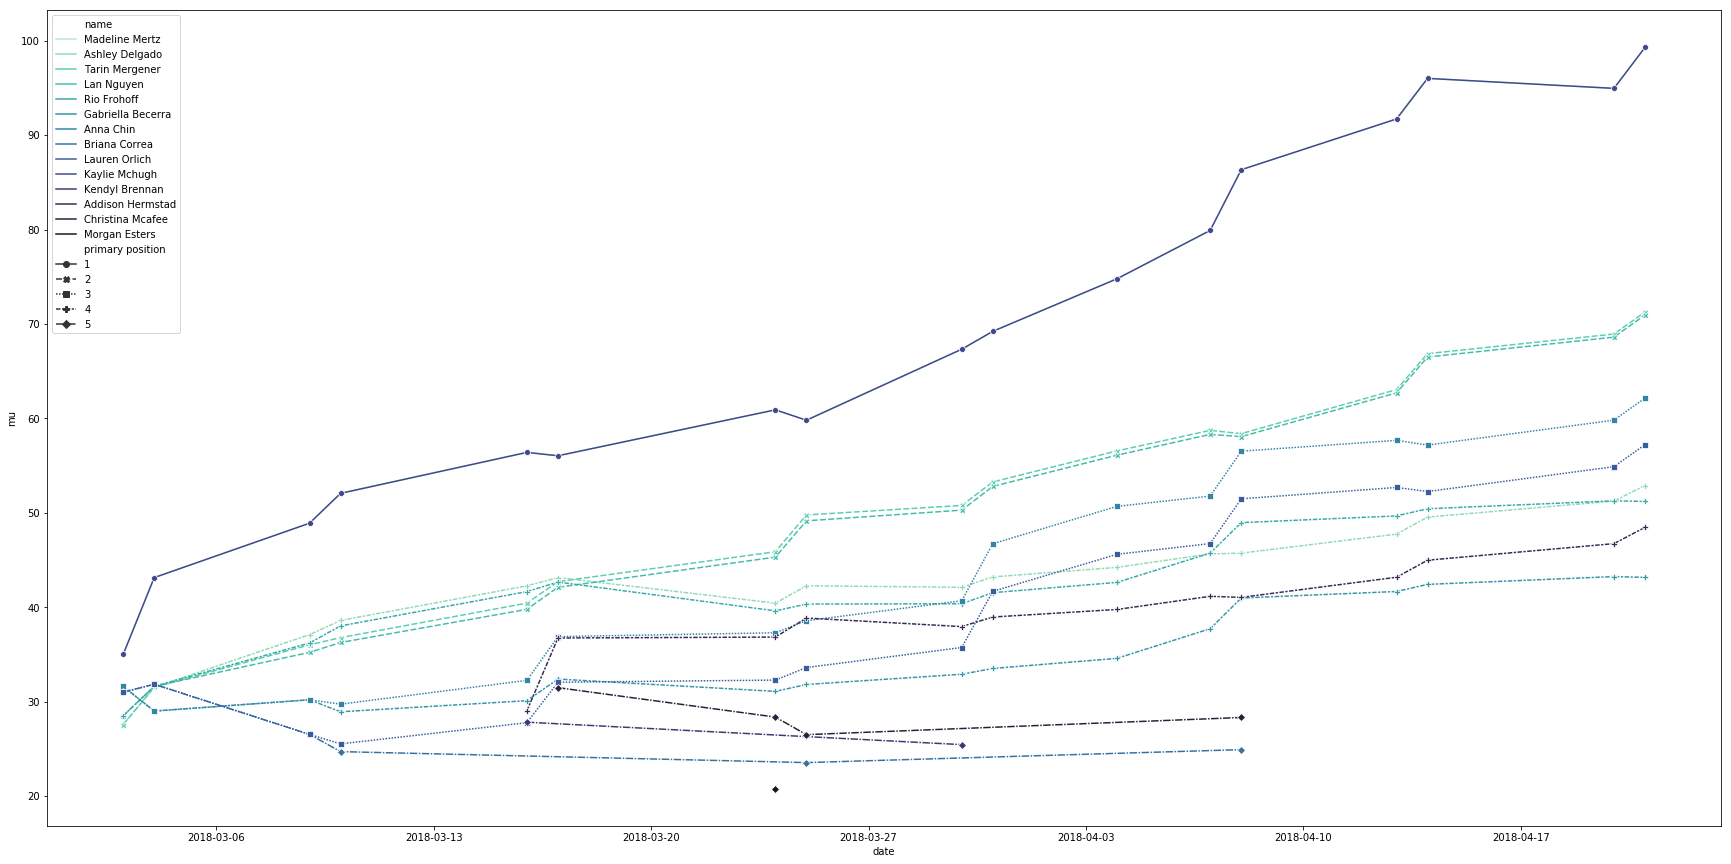

In [311]:
plot_team_players_history(d['match_history'], 'Tulane')
df_top_players[df_top_players.college == 'Tulane'] 

,rank,name,college,division,rating,primary position,date
14,15,Teegan Van Gunst,Georgia State,DI,97.953596,1,2018-04-21
22,23,Annika Van Gunst,Georgia State,DI,93.688722,1,2018-04-21
72,73,Tiffany Creamer,Georgia State,DI,79.834772,2,2018-04-21
80,81,Brooke Weiner,Georgia State,DI,75.662747,2,2018-04-21
112,113,Georgia Johnson,Georgia State,DI,69.114952,3,2018-04-21
120,121,Olivia Stasevich,Georgia State,DI,67.621604,3,2018-04-21
255,256,Amie Held,Georgia State,DI,53.507015,4,2018-04-21
282,283,Kate Novack,Georgia State,DI,50.871306,4,2018-04-21
394,395,Allie Elson,Georgia State,DI,42.722898,5,2018-04-21
425,426,Meagan McCall,Georgia State,DI,40.746271,3,2018-03-24


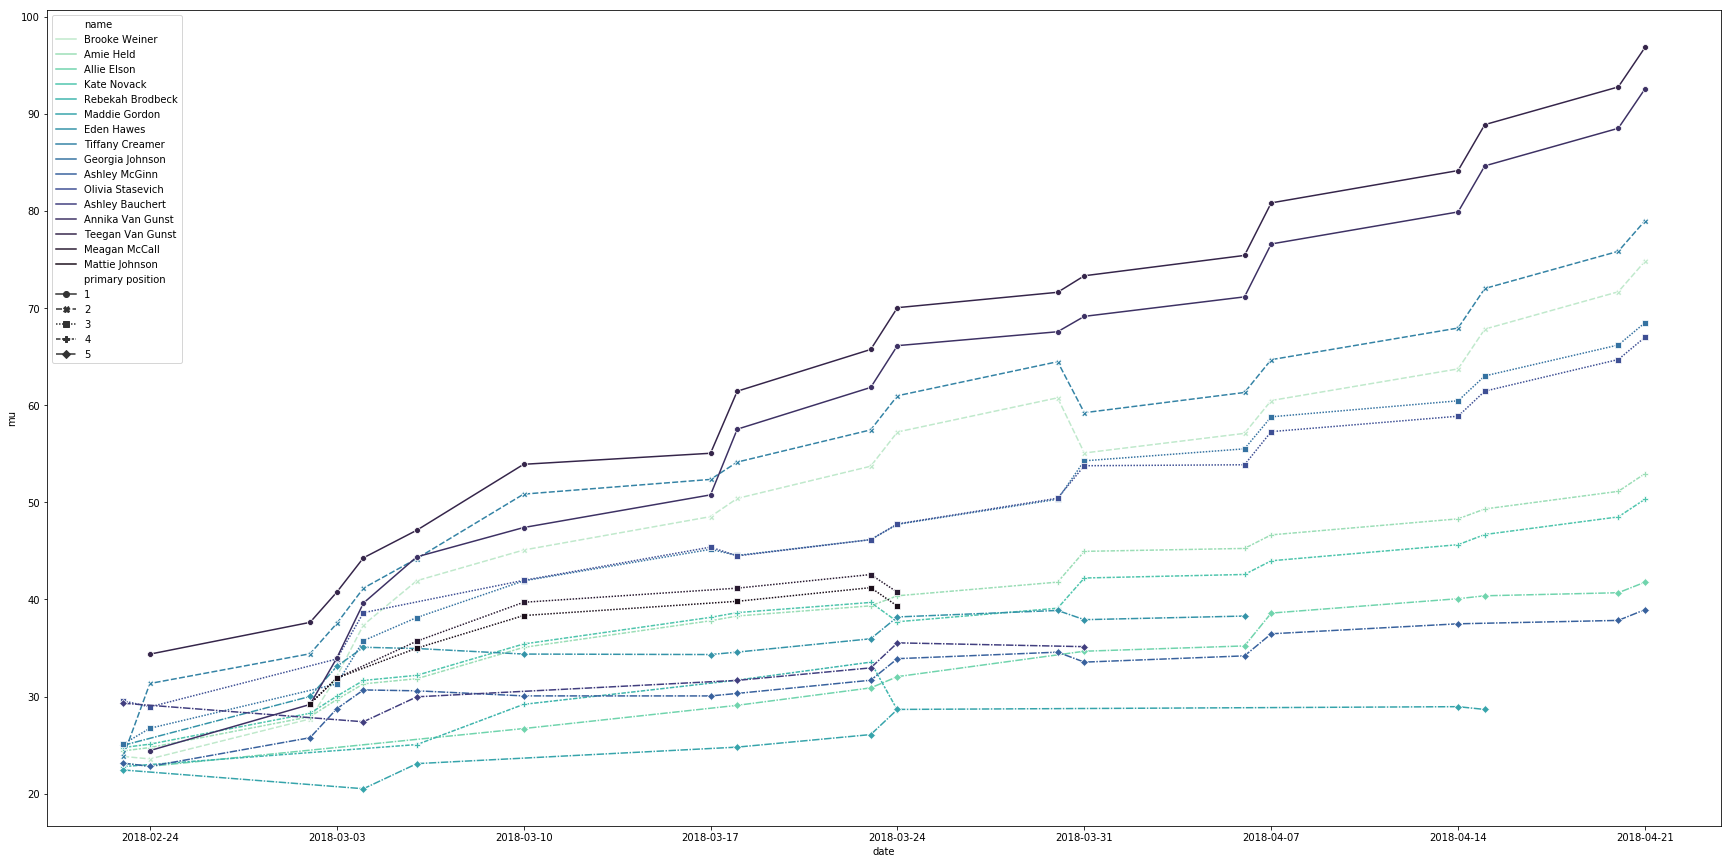

In [313]:
plot_team_players_history(d['match_history'], 'Georgia State')
df_top_players[df_top_players.college == 'Georgia State'] 

,rank,name,college,division,rating,primary position,date
23,24,Jessica Wooten,Houston Baptist,DI,93.480204,1,2018-04-22
24,25,Aeriel Horton,Houston Baptist,DI,93.480204,1,2018-04-22
128,129,Kayla Armer,Houston Baptist,DI,67.038049,2,2018-04-22
129,130,Tori Hinojosa,Houston Baptist,DI,67.038049,2,2018-04-22
341,342,Katya Silveira,Houston Baptist,DI,46.757366,3,2018-04-22
342,343,Bailey Banks,Houston Baptist,DI,46.757366,3,2018-04-22
368,369,Brennan Miller,Houston Baptist,DI,44.229712,4,2018-04-22
408,409,Kali Fluke,Houston Baptist,DI,41.975797,5,2018-04-22
507,508,Danielle Wheeler,Houston Baptist,DI,34.285812,4,2018-04-22
561,562,Jordyn Miller,Houston Baptist,DI,30.395387,4,2018-04-14


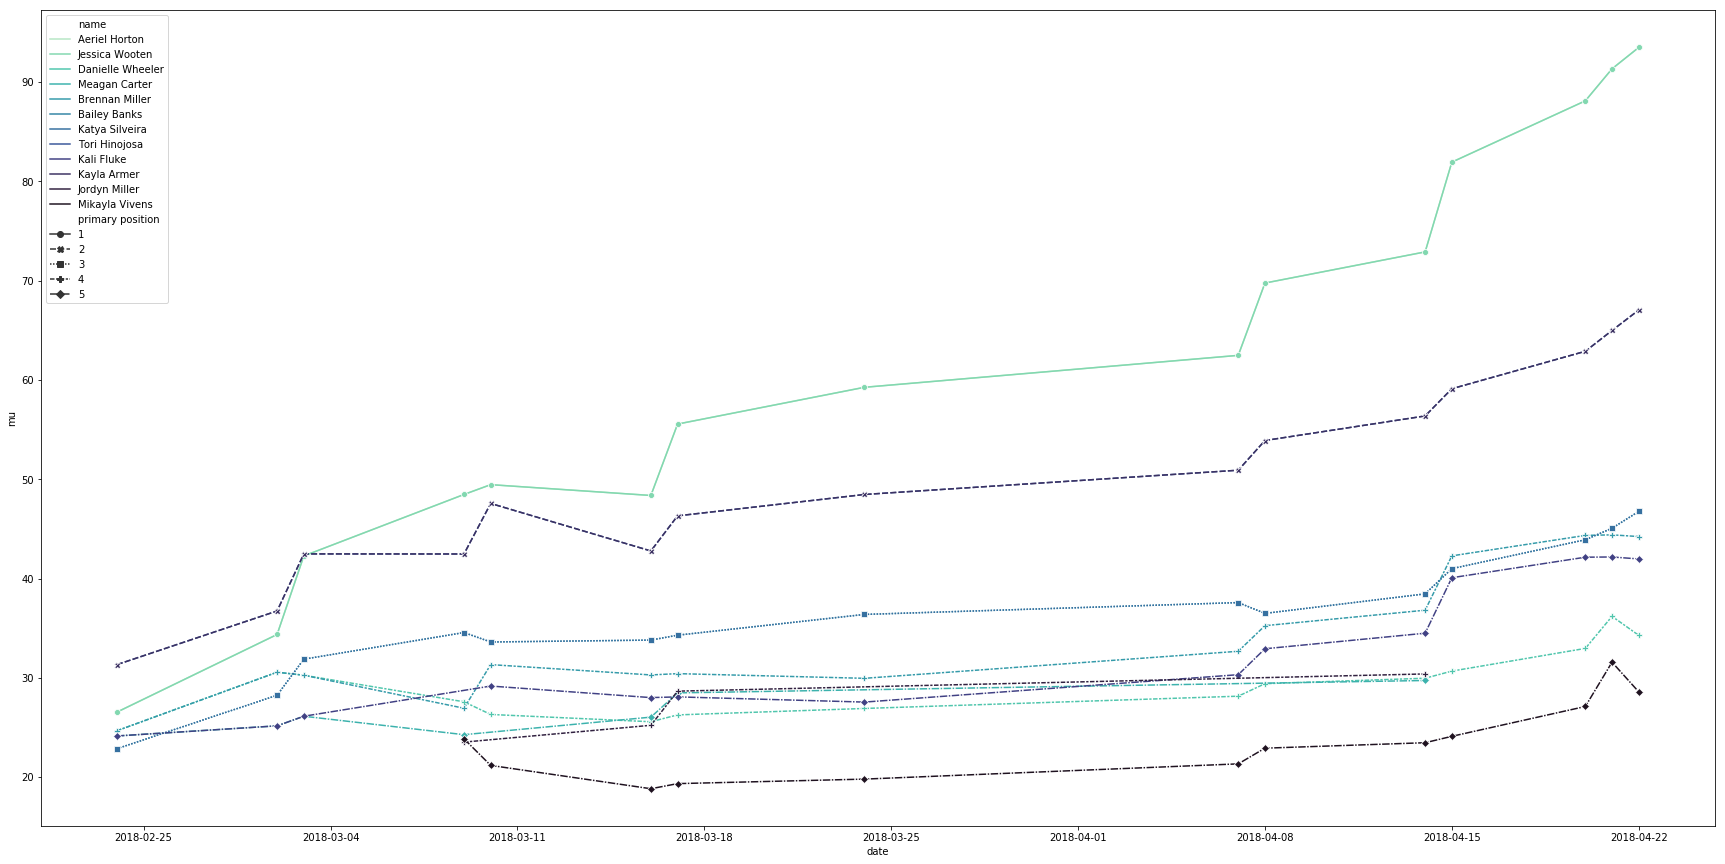

In [314]:
plot_team_players_history(d['match_history'], 'Houston Baptist')
df_top_players[df_top_players.college == 'Houston Baptist'] 

In [35]:
df_top_players[df_top_players.college == 'FAU'] 

,rank,name,college,division,rating,primary position,date
74,75,Carly Scarborough,FAU,DI,78.559317,1,2018-04-21
85,86,Amanda Silva,FAU,DI,75.443465,1,2018-04-21
107,108,Gabrielle Dischler,FAU,DI,69.798688,2,2018-04-21
108,109,Jessalyn Kinlaw,FAU,DI,69.798688,2,2018-04-21
151,152,Erica Brok,FAU,DI,63.021416,3,2018-04-21
203,204,Mackenzie Morris,FAU,DI,58.111655,3,2018-04-21
349,350,Kaila Dorish,FAU,DI,46.115906,4,2018-04-21
358,359,Nicole Navarro,FAU,DI,45.264721,4,2018-04-21
414,415,Julia Lewkowicz,FAU,DI,41.758359,5,2018-04-21
432,433,Brittany Pellitteri,FAU,DI,39.884319,5,2018-04-21


In [130]:
df_top_players[df_top_players.college == 'Stanford'] 

,rank,name,college,division,rating,primary position,date
16,17,Sunny Villapando,Stanford,DI,95.836763,1,2018-04-27
66,67,Amelia Smith,Stanford,DI,81.646806,2,2018-04-27
67,68,Morgan Hentz,Stanford,DI,81.646806,2,2018-04-27
77,78,Courtney Bowen,Stanford,DI,76.543238,3,2018-04-27
139,140,Kate Formico,Stanford,DI,65.230185,3,2018-04-27
195,196,Kathryn Plummer,Stanford,DI,59.290967,1,2018-03-27
226,227,Catherine Raquel,Stanford,DI,56.222461,3,2018-04-27
279,280,Payton Chang,Stanford,DI,51.146952,4,2018-04-27
314,315,Caitlin Keefe,Stanford,DI,48.567323,4,2018-04-27
367,368,Blake Sharp,Stanford,DI,44.238793,5,2018-04-27


## Original Saturday night spread factor

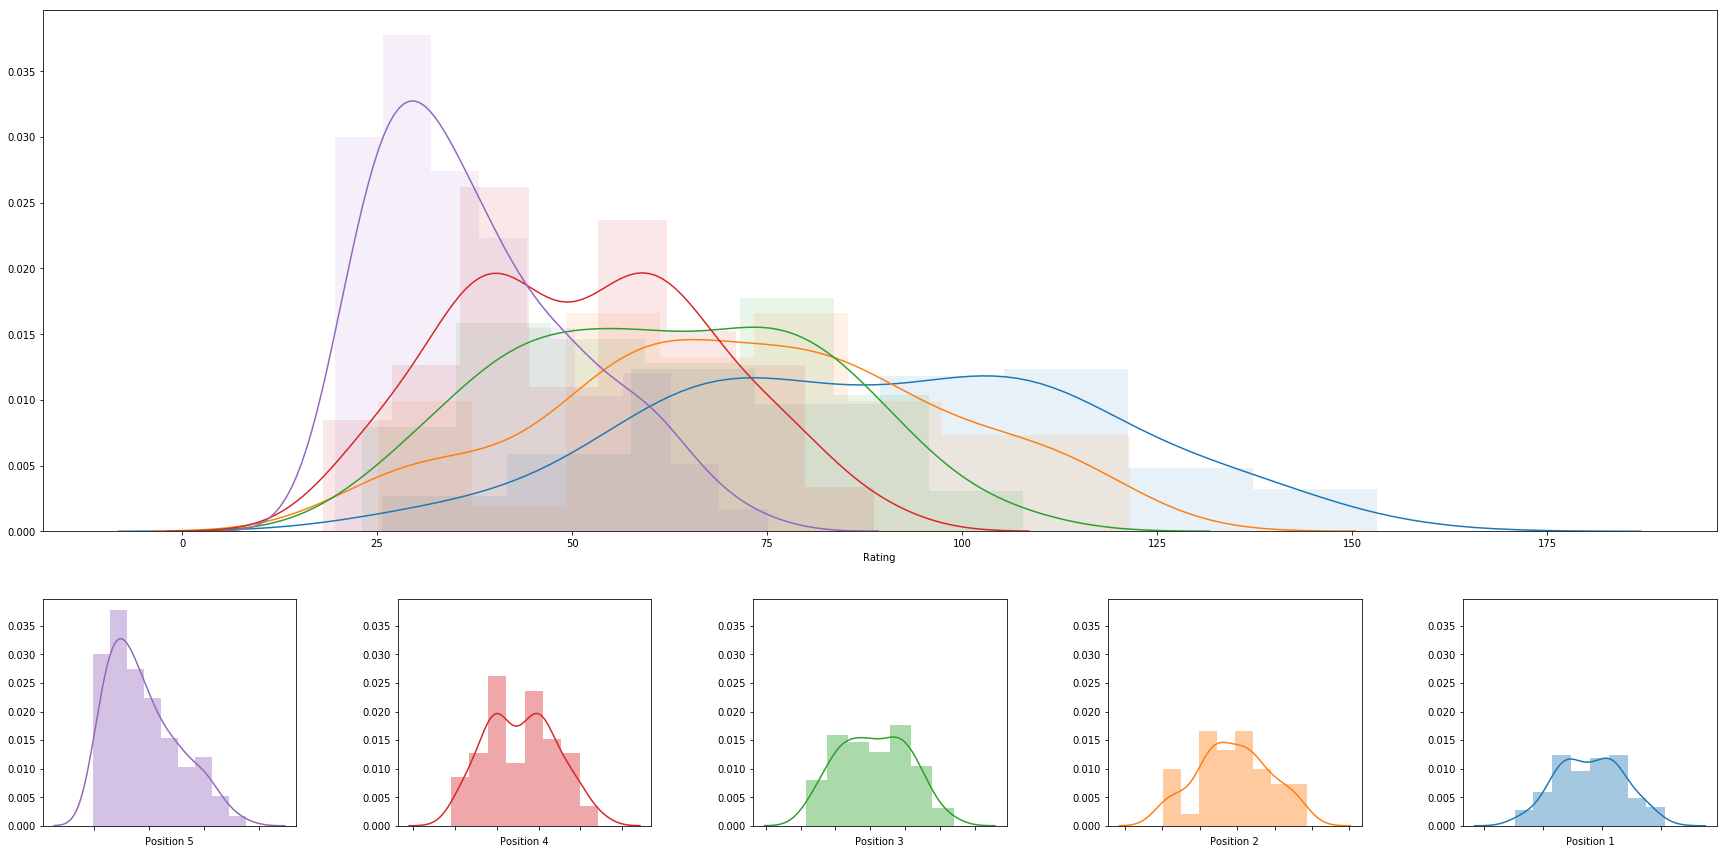

In [562]:
d = create_ratings_from_matches(df, [2.2, 1.5, 1.1, .75, 0])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('220_150_110_075_000.csv')

In [638]:
get_top_players(d['match_history'], position_='all')


,rank,name,college,division,rating,primary position,date
0,1,Abril Bustamante,USC,DI,153.194999,1,2018-05-05
1,2,Ka'iwi Schucht,Hawaii,DI,140.021439,1,2018-05-06
2,3,Emily Maglio,Hawaii,DI,140.021439,1,2018-05-06
3,4,Megan McNamara,UCLA,DI,139.975159,1,2018-05-06
4,5,Nicole McNamara,UCLA,DI,139.975159,1,2018-05-06
5,6,Victoria Paranagua,Florida State,DI,137.520625,1,2018-05-05
6,7,Tina Graudina,USC,DI,136.029994,1,2018-05-05
7,8,Kristen Nuss,LSU,DI,133.308954,1,2018-05-04
8,9,Claire Coppola,LSU,DI,133.308954,1,2018-05-04
9,10,Vanessa Freire,Florida State,DI,129.650646,1,2018-05-05


### Factor logic
- Athletes who have never played in competition for the season, shouldn't show up in ranking. As soon as they compete in a match, their initial rating is 25
- Athletes who have a win/loss record of less than 500 may have ratings lower than players who have never played in competition

KATIE FRIESEN
College: FIU
Division: DI
Primary Position: 3
Last Rating:60.31880433749054


/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma,Partner,Opponent 1,Opponent 2
0,2018-03-30,1351,"Miami, Fl",Katie,Friesen,Katie Friesen,2,3,FIU,DI,0,22.131506,7.389233,Dorina Klinger (43.0112868642),Jessica Stansfield (38.3545836244),Bella Baumann (33.9305925809)
1,2018-03-31,1442,"Miami, Fl",Katie,Friesen,Katie Friesen,2,3,FIU,DI,1,40.486739,6.234374,Dorina Klinger (53.3823484443),Brooke Weiner (53.3483412293),Tiffany Creamer (57.6088055011)
2,2018-04-13,1601,"Miami, Fl",Katie,Friesen,Katie Friesen,2,3,FIU,DI,1,45.301834,5.704541,Dorina Klinger (56.6951875164),Avei Logoleo (55.9171162328),Erin Bognar (41.9280126476)
3,2018-04-14,1629,"Miami, Fl",Katie,Friesen,Katie Friesen,3,3,FIU,DI,1,46.658008,5.617018,Dorina Klinger (57.9635275312),Emily Martinez (41.9269162153),Gabbi Moreno (38.0740471929)
4,2018-04-20,1718,"Emerson, Ga",Katie,Friesen,Katie Friesen,3,3,FIU,DI,1,50.762682,5.151499,Dorina Klinger (60.8325826131),Kennedy Madison (54.6375173694),Riana Brennan (54.6375173694)
5,2018-04-20,1726,"Emerson, Ga",Katie,Friesen,Katie Friesen,3,3,FIU,DI,1,54.291247,4.766650,Dorina Klinger (63.4761544414),Anna Chin (60.0129586191),Lauren Orlich (55.0907339359)
6,2018-04-21,1774,"Emerson, Ga",Katie,Friesen,Katie Friesen,3,3,FIU,DI,0,54.153785,4.515678,Dorina Klinger (63.7669640451),Carly Schneider (63.4390520022),Julia Mannisto (61.7574048639)
7,2018-04-21,1793,"Emerson, Ga",Katie,Friesen,Katie Friesen,3,3,FIU,DI,1,55.457510,4.461484,Dorina Klinger (65.0234791758),Emily Martinez (51.5057591147),Gabbi Moreno (46.7707906917)
8,2018-04-22,1798,"Emerson, Ga (Semis)",Katie,Friesen,Katie Friesen,3,3,FIU,DI,0,56.587709,4.451893,Dorina Klinger (66.1596524502),Macy Jerger (75.596442151),Sara Putt (78.7731025312)
9,2018-05-04,1863,"Gulf Shores, Al",Katie,Friesen,Katie Friesen,3,3,FIU,DI,1,60.318804,4.171579,Anabela Sataric (57.1545067153),Joy Dennis (65.5717185237),Cammie Dorn (53.7985733964)


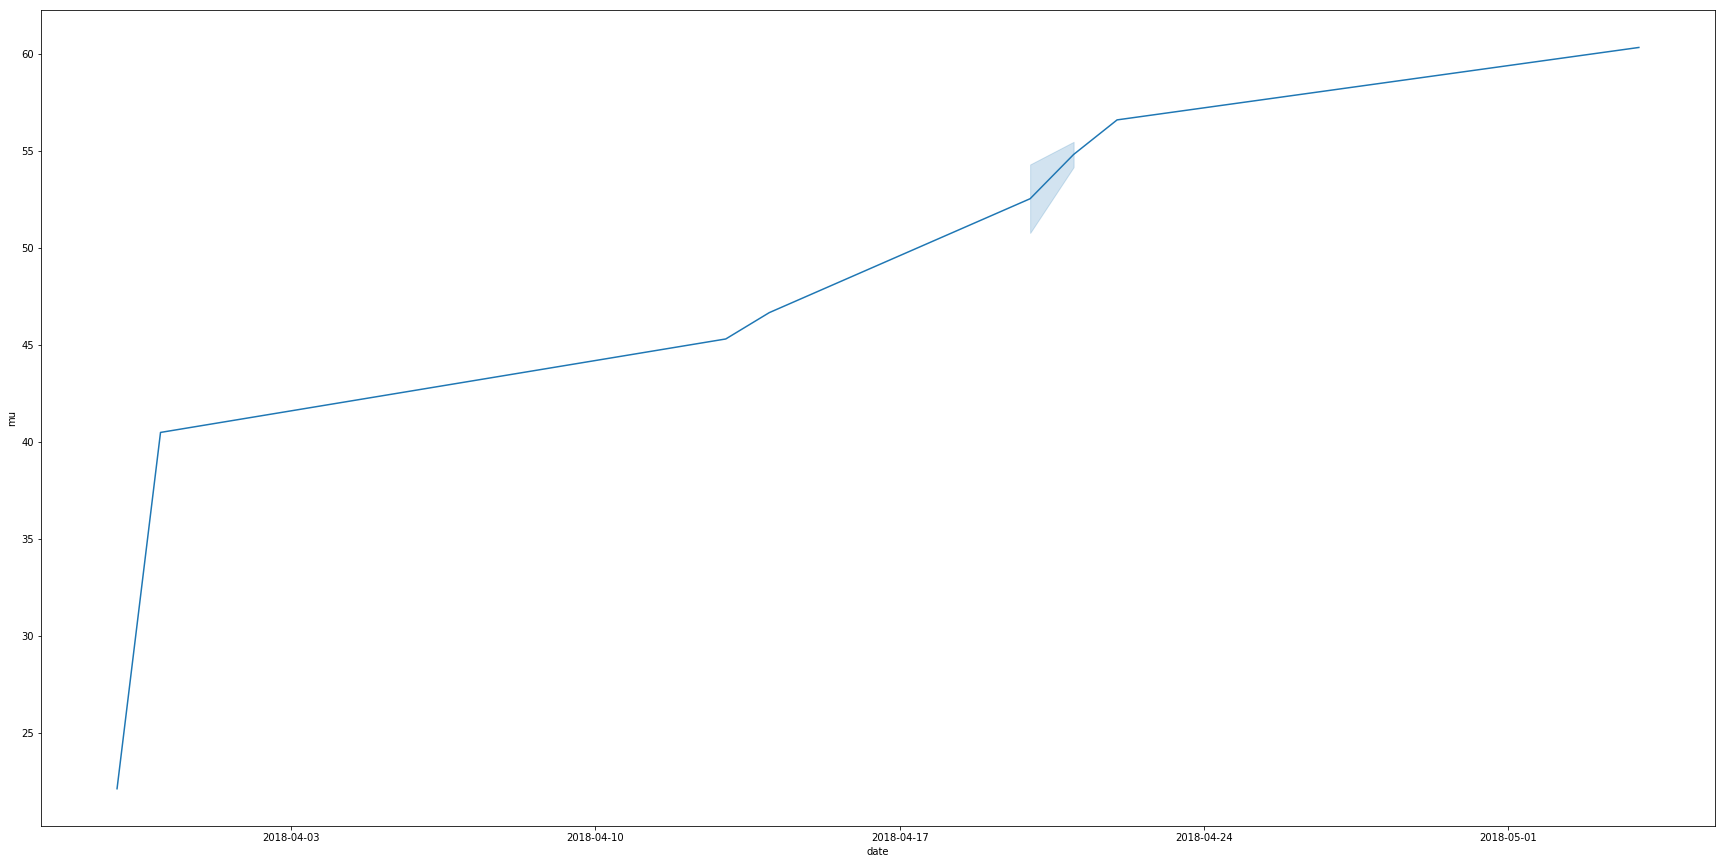

In [310]:
def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    #print temp_df
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df['primary position'].unique()[-1])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    
    temp_df['opponent_result'] = abs(temp_df.result - 1)
    
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    
    df_opp = pd.merge(df[['name', 'mu' ,'compID', 'position', 'result']], \
                       temp_df[['compID', 'position', 'opponent_result']], 
                       left_on=['compID', 'position', 'result'], 
                       right_on=['compID', 'position', 'opponent_result']) \
                .groupby(['compID'])
    
    df_opp1 = df_opp.first().reset_index()[['compID','name', 'mu']]
    df_opp1['Opponent 1'] = df_opp1['name']+' '+df_opp1['mu'].apply(lambda x: '('+str(x)+ ')')
    df_opp2 = df_opp.last().reset_index()[['compID','name', 'mu']]
    df_opp2['Opponent 2'] = df_opp2['name']+' '+df_opp2['mu'].apply(lambda x: '('+str(x)+ ')')
    
    opp = pd.concat([df_opp1, df_opp2], axis=1)
    opp.columns = ['compID', 'name', 'mu', 'Opponent 1', 'compID1', 'name', 'mu','Opponent 2']
    opp = opp[['compID', 'Opponent 1', 'Opponent 2']]
    
    df_summary = pd.merge(df_summary,opp, on='compID')
    df_summary = df_summary[['date', 'compID', 'location', 'first_name', 'last_name', 'name', \
       'position', 'primary position', 'college', 'division', 'result', \
       'mu', 'sigma', 'Partner', 'Opponent 1', 'Opponent 2']] 
    
    return df_summary

a = 'Katie Friesen'
get_player_rating_history(d['match_history'], a)

SHANNON WILLIAMS
College: South Carolina
Division: DI
Primary Position: 1
Last Rating:87.38756869742092


,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma,Partner
0,2018-02-23,800,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,30.258323,7.774363,Ali Denney (30.2583226303)
1,2018-02-23,803,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,0,29.543689,7.268023,Ali Denney (29.5436894516)
2,2018-02-24,823,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,34.393154,6.824538,Ali Denney (34.3931535012)
3,2018-02-24,828,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,37.178767,6.642627,Ali Denney (37.1787666725)
4,2018-03-03,937,"St Augustine, Fl",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,0,34.415204,6.209747,Ali Denney (34.4152042137)
5,2018-03-03,938,"St Augustine, Fl",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,37.261007,6.025856,Ali Denney (37.2610066002)
6,2018-03-04,969,"St. Augustine, Fl",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,43.028701,5.609145,Ali Denney (43.0287014748)
7,2018-03-04,972,"St Augustine, Fl",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,45.537739,5.510109,Ali Denney (45.5377387433)
8,2018-03-10,1049,"Columbia, S.C.",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,0,42.347362,5.218824,Ali Denney (42.3473616675)
9,2018-03-10,1050,"Columbia, S.C.",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,44.807839,5.132202,Ali Denney (44.8078386989)


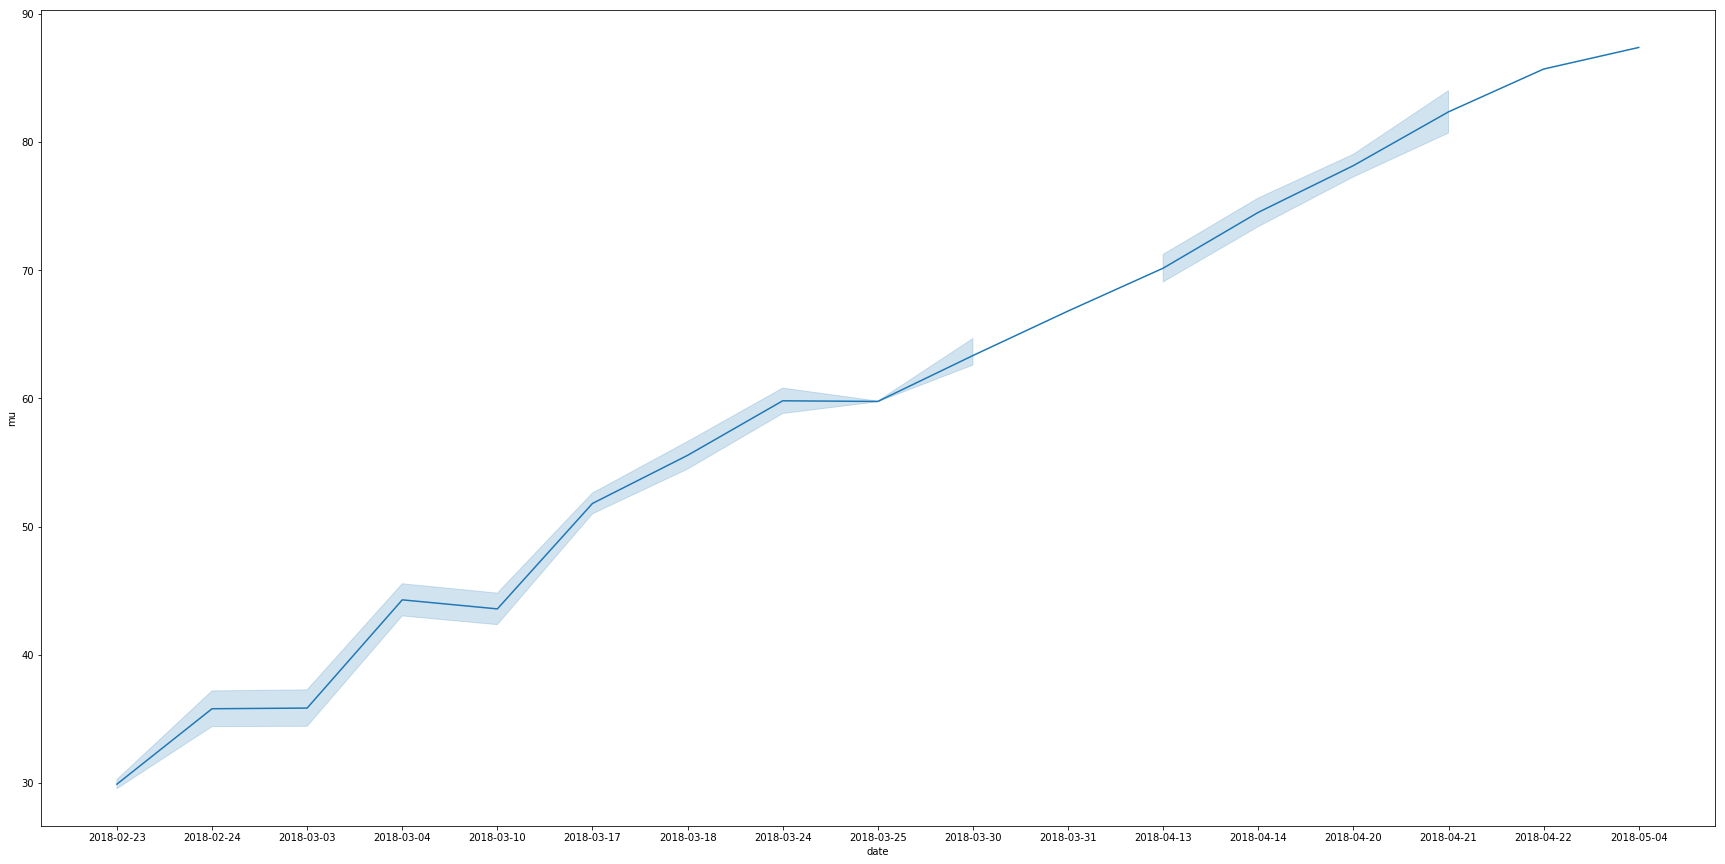

In [273]:
a = 'Shannon Williams'
get_player_rating_history(d['match_history'], a)

# Enter the name of a player to get their rating history

Shannon Williams
SHANNON WILLIAMS
College: South Carolina
Division: DI
Primary Position: 1
Last Rating:87.38756869742092


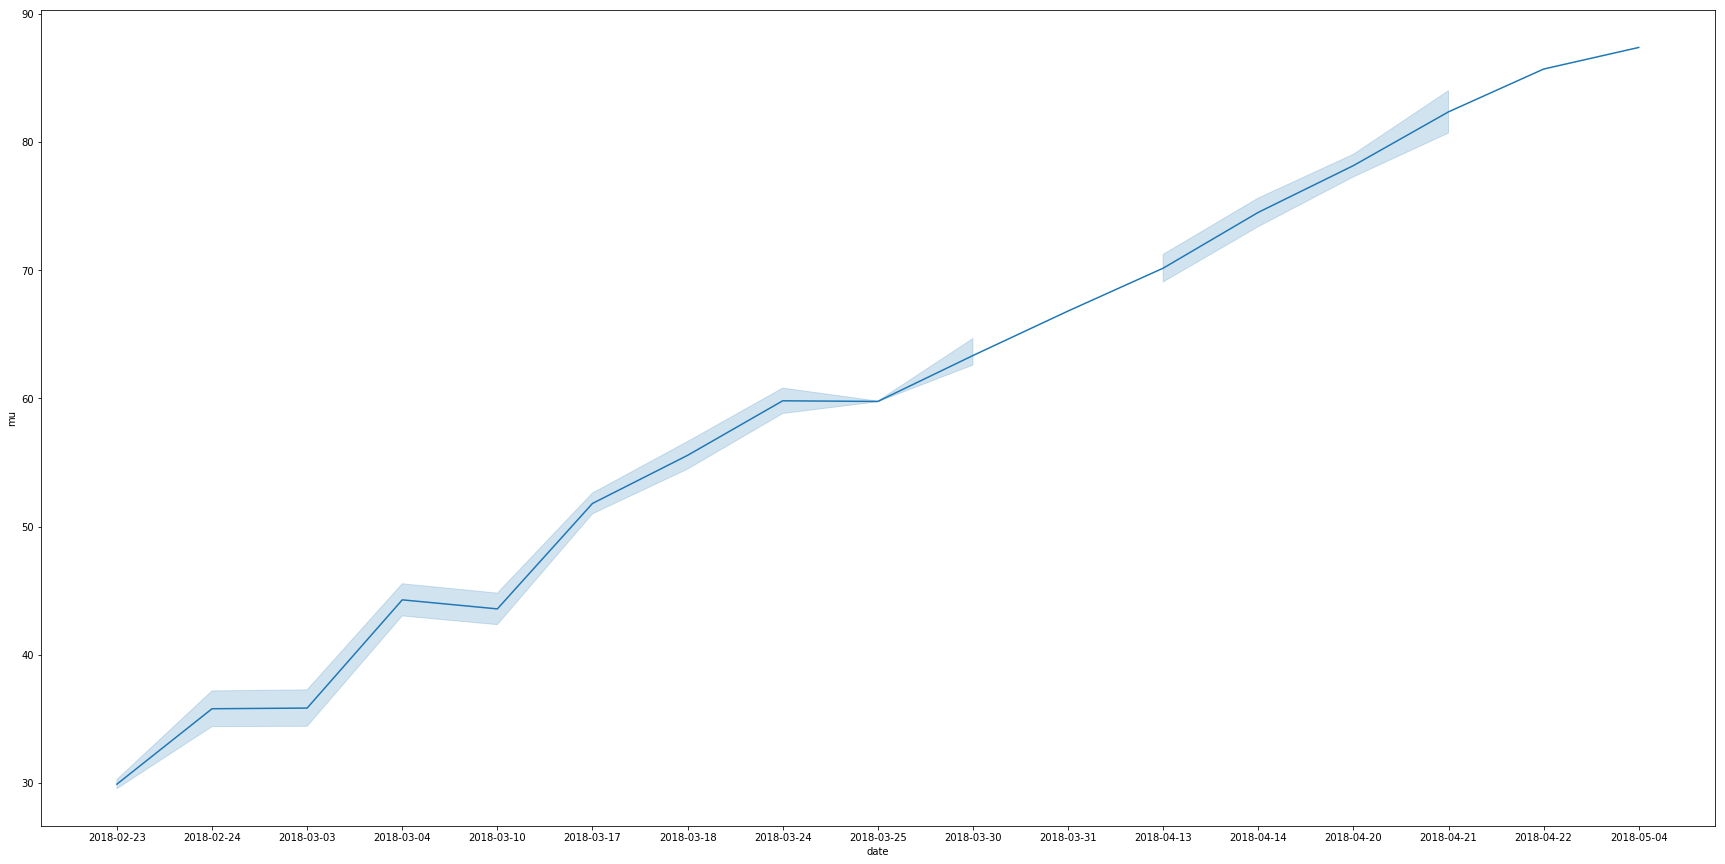

In [272]:
a = raw_input()
get_player_rating_history(d['match_history'], a).to_csv('Shannon Williams.csv')

# Matchups -  Probability of wins

### First get the probability of wins between two pairs

In [83]:
import itertools
import math
BETA = 4.167

def win_probability(team1_, team2_):
    delta_mu = sum(r.mu for r in team1_) - sum(r.mu for r in team2_)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1_, team2_))
    size = len(team1_) + len(team2_)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = global_env()
    return ts.cdf(delta_mu / denom)

#matches = d['match_history']
#matches[(matches.compID == 800) & (matches.position == 1)]

Abril Bustamante and Tina Graudina have a 74.98237153052267 % probability to win against Megan McNamara and Nicole McNamara


(1, 0)

In [120]:
df['name'] = df.first_name + " " + df.last_name

In [124]:

flight1 = ['Abril Bustamante','Tina Graudina','Megan McNamara','Nicole McNamara']
flight2 = df[(df.compID == 1873) & (df.position == 2)].sort_values(['position', 'college'])
flight2 = [a.strip() for a in flight2.name]

flight3 = df[(df.compID == 1873) & (df.position == 3)].sort_values(['position', 'college'])
flight3 = [a.strip() for a in flight3.name]
flight3

flight4 = df[(df.compID == 1873) & (df.position == 4)].sort_values(['position', 'college'])
flight4 = [a.strip() for a in flight4.name]
flight4

flight5 = df[(df.compID == 1873) & (df.position == 5)].sort_values(['position', 'college'])
flight5 = [a.strip() for a in flight5.name]
flight5

duel_dict = {1: flight1, 2: flight2, 3: flight3, 4:flight4, 5:flight5}
duel_dict.keys()
#predict_pair_matchup(d['match_history'], flight1), predict_pair_matchup(d['match_history'], flight3), predict_pair_matchup(d['match_history'], flight4), predict_pair_matchup(d['match_history'], flight5)

[1, 2, 3, 4, 5]

In [270]:
def get_pair_matchup_probability(df, player_list):
    t1p1 = Rating(get_player_rating(df, player_list[0]))
    t1p2 = Rating(get_player_rating(df, player_list[1]))
    t2p1 = Rating(get_player_rating(df, player_list[2]))
    t2p2 = Rating(get_player_rating(df, player_list[3]))
    #print t1p1, t1p2, t2p1, t2p2
    print player_list[0], 'and', player_list[1], "have a", win_probability([t1p1,t1p2], [t2p1, t2p2])*100, \
        "% probability to win against", player_list[2], "and", player_list[3], "."
    return win_probability([t1p1,t1p2], [t2p1, t2p2])

def predict_pair_matchup(df,player_list):
    p = get_pair_matchup_probability(df, player_list)
    if p > .55:
        t1 = 1
        t2 = 0
    elif p < .45:
        t1 = 0
        t2 = 1
    else:
        t1 = 0
        t2 = 0
    return t1, t2

def get_duel_dict(df, team1, team2):
    duel_dict = {}
    for i in range(1,6):
        flight1_1 = list(df_top_players[(df_top_players.college == team1) & (df_top_players['primary position'] == i)][:2].name)
        flight1_2 = list(df_top_players[(df_top_players.college == team2) & (df_top_players['primary position'] == i)][:2].name)
        duel_dict[i] = flight1_1+flight1_2
    return duel_dict

def predict_duel_matchup(df, team1, team2):
    duel_dict = get_duel_dict(d['match_history'], team1, team2)
    t1 = 0
    t2 = 0
    for i in duel_dict.keys():
        temp_t = predict_pair_matchup(df, duel_dict[i])
        #print temp_t
        t1 += temp_t[0]
        t2 += temp_t[1]
    
    print "\n"
    
    if t1 > t2:
        print team1, "is predicted to win the duel", t1, "-", t2
    else:
        print team2, "is predicted to win the duel", t2, "-", t1
    
    return t1, t2

predict_duel_matchup(d['match_history'], 'South Carolina', 'Stanford') 

Shannon Williams and Ali Denney have a 96.00906423410372 % probability to win against Sunny Villapando and Kathryn Plummer .
Katie Smith and Cadie Bates have a 94.87318039239324 % probability to win against Amelia Smith and Morgan Hentz .
Carly Schneider and Julia Mannisto have a 8.489862196147321 % probability to win against Courtney Bowen and Kate Formico .
Macie Tendrich and Leah Perri have a 96.90165664211248 % probability to win against Payton Chang and Caitlin Keefe .
Caroline Skaff and Jess Vastine have a 16.861254123134366 % probability to win against Blake Sharp and Shannon Richardson .


South Carolina is predicted to win the duel 3 - 2


(3, 2)

# Preseason Rankings - non senior players

Need team rosters

In [ ]:
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5

In [ ]:




    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma
0,2018-02-23,800,"Deland, FL",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,0,23.291677,7.774363
37,2018-02-23,800,"Deland, FL",Brooke,Weiner,Brooke Weiner,1,2,Georgia State,DI,0,23.291677,7.774363
74,2018-02-23,800,"Deland, FL",Ali,Denney,Ali Denney,1,1,South Carolina,DI,1,29.508323,7.774363
107,2018-02-23,800,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,29.508323,7.774363


In [ ]:


def actual_match(compid_, df_):
    return df_[df_['Compid'].astype(int) == compid_].groupby('Winner')['Position'].count()

actual_match(1863, df_matchups)

def predict_match(compid, df):
    match = df[df['Compid'].astype(int) == compid].copy().reset_index().iloc[:,1:]
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
            #match[i] = r[i]
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5
        
    
    return match

_df = {}
temp = None
for a in range(780, 1870):
    print a,
    _df = predict_match(a, df_matchups)
    _df = pd.concat([_df, temp], axis=0)
    temp = _df


total_no_draw = len(_df[_df['Winner'] != 'Draw'])
accurate = len(_df[_df['Winner'] == _df['Predicted Winner']])
print accurate, total_no_draw, accurate*100/total_no_draw

_df



In [ ]:
# Predict a Match

ef predictMatch(_compid, _df):
    _match = df_all_matchups[df_all_matchups['CompID'] == _compid].iloc[:,0:5]
    wins = {}

    for i in range(0,len(_match)):
        r = [Rating(lookupPlayerRating(_match.iloc[i,j], predict_ranking))  for j in range(1,5)]

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        win_prob = win_probability(t1, t2)

        #print [(_match.iloc[i,j]+"("+lookupPlayer(_match.iloc[i,j], _df)['Team']+")") for j in range(1,5) ],

        if win_prob > .50:
            val = max(lookupPlayer(_match.iloc[i, 1], _df)['Team'], lookupPlayer(_match.iloc[i, 2], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        elif win_prob < .50:
            val = max(lookupPlayer(_match.iloc[i, 3], _df)['Team'], lookupPlayer(_match.iloc[i, 4], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        else:
            val = 'Draw'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
                
    match_winner = max(wins.iteritems(), key=operator.itemgetter(1))[0]      
    
    return wins, match_winner

print "Predicted:" + str(predictMatch(1816, df_player_ratings))
print "Actual:" + str(actualMatch(1816, df_player_ratings))